# LST-MONO UniPD
Like for CTLearn, results are stored in HDF5 format using pandas. 

### Import libraries
First, we need to import some libraries. 

In [1]:
# Data handling with numpy
import numpy as np
import h5py
#np.set_printoptions(threshold=np.inf)

# Metric handling wit sklearn
from sklearn import metrics

# Reading the HDF5 file with pandas
import pandas as pd

# Plotting libraries
import ctaplot
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import plot_irf

# (Default ctaplot) energy binning 
E_bin = np.logspace(np.log10(2.51e-02), 2, 19)
E = ctaplot.ana.logbin_mean(E_bin)
print(E_bin.shape, E.shape)

(19,) (18,)


## Create the output file


In [2]:
files = {}
files['separation'] = {'Nocut': '/home/pietro/CTA/results/cuts_before/separation/nocuts_0.77350_0.76263.pkl',
                     'Lowcut': '/home/pietro/CTA/results/cuts_before/separation/lowcuts_0.79897_0.78493.pkl',
                     'Midcut': '/home/pietro/CTA/results/cuts_before/separation/midcuts_0.84833_0.83863.pkl',
                     'Highcut': '/home/pietro/CTA/results/cuts_before/separation/highcuts_0.93938_0.92490.pkl'
                      }
files['regression'] = {'Nocut': '/home/pietro/CTA/results/cuts_before/regression/nocuts_0.24573_0.25495.pkl',
                   'Lowcut': '/home/pietro/CTA/results/cuts_before/regression/lowcuts_0.21761_0.22290.pkl',
                   'Midcut': '/home/pietro/CTA/results/cuts_before/regression/midcuts_0.15944_0.17980.pkl',
                   'Highcut': '/home/pietro/CTA/results/cuts_before/regression/highcuts_0.06644_0.10034.pkl'
                   }

file = 'Highcut'
metric = []
metric_keys = []
data_sep = pd.read_pickle(files['separation'][file])
data_reg = pd.read_pickle(files['regression'][file])
print(data_sep.columns)
print(data_reg.columns)

Index(['energy_true', 'energy_reco', 'class', 'gammaness'], dtype='object')
Index(['energy_true', 'energy_reco', 'd_alt_true', 'd_az_true', 'd_alt_reco',
       'd_az_reco'],
      dtype='object')


In [3]:
files = {}
files['separation'] = {'Nocut': '/home/pietro/CTA/results/cuts_before/separation/nocuts_0.77350_0.76263.pkl',
                     'Lowcut': '/home/pietro/CTA/results/cuts_before/separation/lowcuts_0.79897_0.78493.pkl',
                     'Midcut': '/home/pietro/CTA/results/cuts_before/separation/midcuts_0.84833_0.83863.pkl',
                     'Highcut': '/home/pietro/CTA/results/cuts_before/separation/highcuts_0.93938_0.92490.pkl'
                      }
files['regression'] = {'Nocut': '/home/pietro/CTA/results/cuts_before/regression/nocuts_0.24573_0.25495.pkl',
                   'Lowcut': '/home/pietro/CTA/results/cuts_before/regression/lowcuts_0.21761_0.22290.pkl',
                   'Midcut': '/home/pietro/CTA/results/cuts_before/regression/midcuts_0.15944_0.17980.pkl',
                   'Highcut': '/home/pietro/CTA/results/cuts_before/regression/highcuts_0.06644_0.10034.pkl'
                   }

cnn = 'VGG16'
gammatyp = 'pointlike'

output_file_name = '/home/pietro/CTA/LSTmono_unipd.h5'
output_file = pd.HDFStore(output_file_name, 'w')
# Particle classification
particle_metrics = {}
particle_key_label = '{}/Particle_classification'.format(cnn)

for file in files['separation']:
    print(file)
    metric = []
    metric_keys = []
    data = pd.read_pickle(files['separation'][file])
    
    proton_prediction = data[data['class']==0]
    proton_mc_particle = np.array(proton_prediction['class']).astype(int)
    proton_reco_particle = np.array(proton_prediction['gammaness']).round().astype(int)
    proton_reco_gammaness = np.array(proton_prediction['gammaness']).astype(float)
    

    gamma_prediction = data[data['class']==1]
    gamma_mc_particle = np.array(gamma_prediction['class']).astype(int)
    gamma_reco_particle = np.array(gamma_prediction['gammaness']).round().astype(int)
    gamma_reco_gammaness = np.array(gamma_prediction['gammaness']).astype(float)
    
    mc_particle = np.array(data['class']).astype(int) #np.concatenate((proton_mc_particle, gamma_mc_particle))
    reco_particle = np.array(data['gammaness']).round().astype(int) #np.concatenate((proton_reco_particle, gamma_reco_particle))
    reco_gammaness = np.array(data['gammaness']).astype(float) #np.concatenate((proton_reco_gammaness, gamma_reco_gammaness))
    
    fpr, tpr, thresholds = metrics.roc_curve(mc_particle, reco_gammaness)
    
    # AUC
    metric.append(metrics.auc(fpr, tpr))
    metric_keys.append('AUC_{}'.format(gammatyp))
    # Acc score for the protons and gammas (pointlike)
    metric.append(metrics.accuracy_score(mc_particle, reco_particle))
    metric_keys.append('Acc_{}'.format(gammatyp))
    # Acc score for the gammas (pointlike) only
    metric.append(metrics.accuracy_score(gamma_mc_particle, gamma_reco_particle))
    metric_keys.append('Acc_gamma_{}'.format(gammatyp))
    # Acc score for the protons only
    metric.append(metrics.accuracy_score(proton_mc_particle, proton_reco_particle))
    metric_keys.append('Acc_proton')

    particle_metrics['{}'.format(file)] = metric

    for k, m in zip(metric_keys, metric):
        print("{} = {:0.3f}".format(k, m))
        
if particle_key_label in list(output_file.keys()):
    output_file.remove(particle_key_label)
pd.DataFrame(data=particle_metrics).to_hdf(output_file_name, key=particle_key_label, mode='a')



energy_datapoints = {}
energy_key_label = '{}/Energy_regression'.format(cnn)
arrdir_datapoints = {}
arrdir_key_label = '{}/ArrivalDirection_regression'.format(cnn)

for cut in ['Nocut', 'Lowcut', 'Midcut', 'Highcut']:
    data = pd.read_pickle(files['regression'][cut])
    #prediction_data = data['gamma_{}'.format(gammatyp)]
    mc_energy = np.power(10,np.array(data['energy_true']))
    reco_energy = np.power(10,np.array(data['energy_reco']))
    mc_alt = np.array(data['d_alt_true'])
    reco_alt = np.array(data['d_alt_reco'])
    mc_az = np.array(data['d_az_true'])
    reco_az = np.array(data['d_az_reco'])
    
    # Energy resolution
    #ebin, eres = ctaplot.ana.ana.resolution_per_bin(x=mc_energy, y_true=mc_energy, y_reco=reco_energy, bins=10)
    ebin, eres = ctaplot.ana.energy_resolution_per_energy(mc_energy, reco_energy, bias_correction=True)
    #print("ebin shape", ebin.shape)
    #print("eres shape", eres.shape)
    energy_datapoints['Energy_resolution_{}_{}'.format(gammatyp, cut)] = eres[:,0]
    energy_datapoints['Energy_resolution_lower_{}_{}'.format(gammatyp, cut)] = eres[:,1]
    energy_datapoints['Energy_resolution_upper_{}_{}'.format(gammatyp, cut)] = eres[:,2]
    # Energy bias
    #ebin, energy_datapoints['Energy_bias_{}_{}'.format(gammatyp, cut)] = ctaplot.ana.bias_per_bin(mc_energy, reco_energy, x=mc_energy)
    ebin, energy_datapoints['Energy_bias_{}_{}'.format(gammatyp, cut)] = ctaplot.ana.energy_bias(mc_energy, reco_energy)
    # Angular resolution
    ebin, angres = ctaplot.ana.angular_resolution_per_energy(mc_alt, mc_az, reco_alt, reco_az, reco_energy)
    #ebin, angres = ctaplot.ana.angular_resolution_per_bin(reco_alt, reco_az, mc_alt, mc_az, reco_energy, bins=10)
    print("ang ebin shape", ebin.shape)
    print("angres shape", angres.shape)
    #angres = np.degrees(angres)
    arrdir_datapoints['Angular_resolution_{}_{}'.format(gammatyp, cut)] = angres[:,0]
    arrdir_datapoints['Angular_resolution_lower_{}_{}'.format(gammatyp, cut)] = angres[:,1]
    arrdir_datapoints['Angular_resolution_upper_{}_{}'.format(gammatyp, cut)] = angres[:,2]
    
if energy_key_label in list(output_file.keys()):
    output_file.remove(energy_key_label)
pd.DataFrame(data=energy_datapoints).to_hdf(output_file_name, key=energy_key_label, mode='a')
if arrdir_key_label in list(output_file.keys()):
    output_file.remove(arrdir_key_label)
pd.DataFrame(data=arrdir_datapoints).to_hdf(output_file_name, key=arrdir_key_label, mode='a')


rf = 'rf'
rf_energy_datapoints = {}
rf_energy_key_label = '{}/Energy_regression'.format(rf)
rf_arrdir_datapoints = {}
rf_arrdir_key_label = '{}/ArrivalDirection_regression'.format(rf)

print("Results saved in '{}'".format(output_file_name))

Nocut
AUC_pointlike = 0.874
Acc_pointlike = 0.781
Acc_gamma_pointlike = 0.835
Acc_proton = 0.726
Lowcut
AUC_pointlike = 0.883
Acc_pointlike = 0.790
Acc_gamma_pointlike = 0.808
Acc_proton = 0.773
Midcut
AUC_pointlike = 0.929
Acc_pointlike = 0.849
Acc_gamma_pointlike = 0.849
Acc_proton = 0.848
Highcut
AUC_pointlike = 0.986
Acc_pointlike = 0.949
Acc_gamma_pointlike = 0.959
Acc_proton = 0.938
ang ebin shape (19,)
angres shape (18, 3)
ang ebin shape (19,)
angres shape (18, 3)
ang ebin shape (19,)
angres shape (18, 3)
ang ebin shape (19,)
angres shape (18, 3)
Results saved in '/home/pietro/CTA/LSTmono_unipd.h5'


In [4]:
output_file.close()

### ROC curves

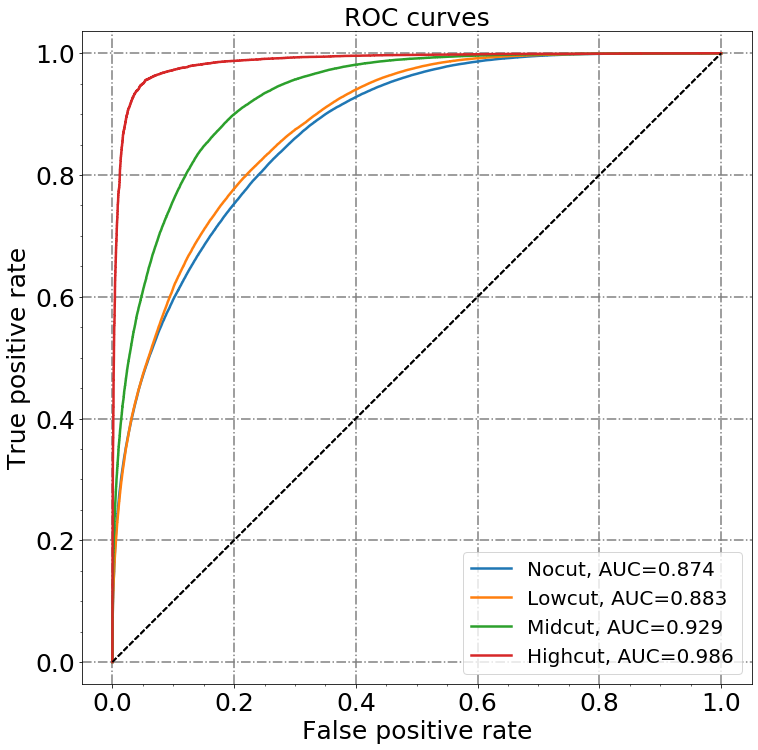

In [5]:
gammatyp='pointlike'
plt.figure(figsize=(12,12))
ax = plt.axes() 
for file in files['separation']:
    data = pd.read_pickle(files['separation'][file])
    mc_particle = np.array(data['class']).astype(int) #np.concatenate((proton_mc_particle, gamma_mc_particle))
    reco_particle = np.array(data['gammaness']).round().astype(int) #np.concatenate((proton_reco_particle, gamma_reco_particle))
    reco_gammaness = np.array(data['gammaness']).astype(float) #np.concatenate((proton_reco_gammaness, gamma_reco_gammaness))
    fpr, tpr, thresholds = metrics.roc_curve(mc_particle, reco_gammaness)
    ax = ctaplot.plot_roc_curve(mc_particle, reco_gammaness, lw=2.5, label="{}, AUC={:0.3f}".format(file, metrics.auc(fpr, tpr)))
        
ax.set_xlabel('False positive rate', fontsize=25)
#plt.xlim(0.0,1.0)
ax.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])

ax.set_ylabel('True positive rate', fontsize=25)
#plt.ylim(0.0,1.0)
ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])

ax.plot([0, 1], [0, 1], '--', color='black')
#major grid lines
ax.tick_params(labelsize=25)

ax.legend(loc='lower right',fontsize=20)
#ax.text(0.5, 0.5, 'Preliminary', fontsize=58, alpha=0.5, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.grid(b=True, which='major', color='gray', linestyle='dashdot', lw=1.5)
plt.minorticks_on()
#plt.grid(b=True, which='minor', color='gray', alpha=0.2, ls='-', lw=1)
ax.set_title("ROC curves",fontsize=25)
plt.savefig("/home/pietro/CTA/results/cuts_before/separation/roc_curves_{}.png".format(gammatyp))
plt.savefig("/home/pietro/CTA/PRESENTATION/fig/roc_curves_{}.pdf".format(gammatyp), bbox_inches="tight")
plt.savefig("/home/pietro/CTA/PRESENTATION/fig/roc_curves_{}.png".format(gammatyp), bbox_inches="tight")

plt.show()

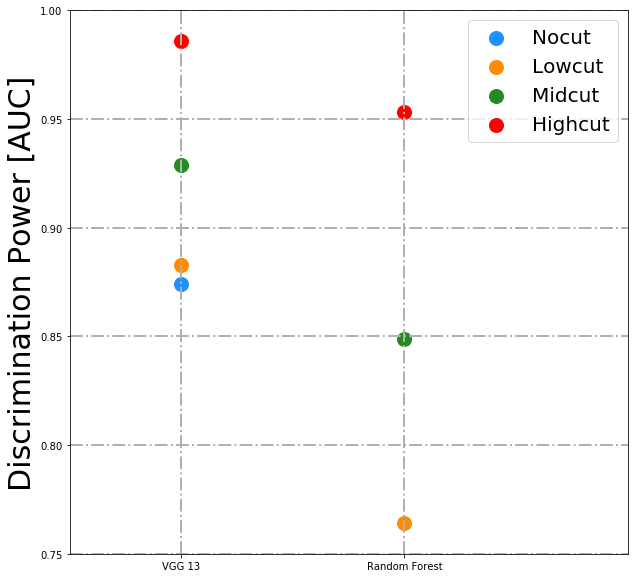

In [6]:
plt.figure(figsize=(10,10))
matplotlib.rcParams.update({'lines.markersize': 14})
plt.grid(linestyle='-.', axis='both', lw=2)
vgg_auc = [0.874, 0.883, 0.929, 0.986]
rf_auc = [0.764, 0.849, 0.953]
plt.scatter('VGG 13', vgg_auc[0], color='dodgerblue', label="Nocut")

plt.scatter('VGG 13', vgg_auc[1], color='darkorange',label="Lowcut")
plt.scatter('Random Forest', rf_auc[0], color='darkorange')

plt.scatter('VGG 13', vgg_auc[2], color='forestgreen', label='Midcut')
plt.scatter('Random Forest', rf_auc[1], color='forestgreen')

plt.scatter('VGG 13', vgg_auc[3], color='red',label="Highcut")
plt.scatter('Random Forest', rf_auc[2], color='red')
axes = plt.gca()
#plt.grid(linestyle='--')
axes.set_ylim([0.75,1])
axes.set_xlim([-.5,2])

plt.grid(which='minor', linestyle='--', lw=0.8)
plt.legend(fontsize=20)
plt.ylabel("Discrimination Power [AUC]", fontsize=30)
plt.savefig("/mnt/Dati/CTA/PRESENTATION/fig/auc_vs_rf.png", bbox_inches='tight')

In [7]:
data = pd.read_pickle(files['separation']['Midcut'])
print(np.unique(data['class'], return_counts=True))

(array([0., 1.]), array([92034, 92034]))


Index(['energy_true', 'energy_reco', 'class', 'gammaness'], dtype='object')
(array([0., 1.]), array([92034, 92034]))


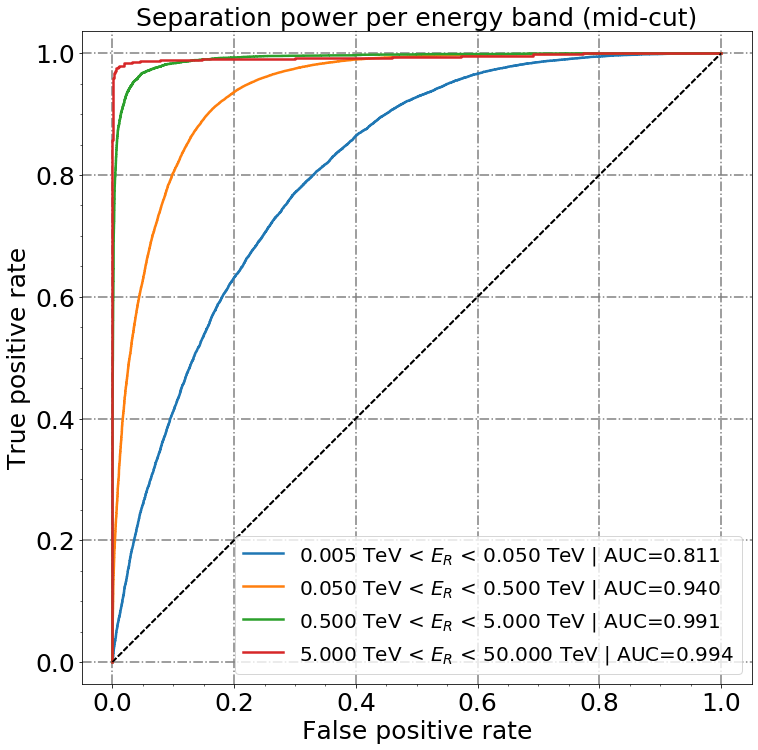

In [8]:
cut = 'Midcut'
init = 0
if cut == 'Highcut':
    init = 1
data = pd.read_pickle(files['separation'][cut])
print(data.columns)
print(np.unique(data["class"], return_counts=True))
mb = np.linspace(np.log10(0.5e-02), 1.6989700043360187, 5)
#mb = np.linspace(np.log10(0.1e-01), np.log10(100), 5)



er = data['energy_reco']
#er = data['energy_true']
plt.figure(figsize=(12,12))
ax = plt.axes()
ax.set_ylabel('True positive rate', fontsize=25)
ax.set_xlabel('False positive rate', fontsize=25)
ax.set_title('Separation power per energy band (mid-cut)', fontsize=25)
plt.grid(b=True, which='major', color='gray', linestyle='dashdot', lw=1.5)
plt.minorticks_on()
#plt.grid(b=True, which='minor', color='gray', alpha=0.2, ls='-', lw=1)

for i in range(init,len(mb)-1):
    mc_particle = np.array(data[(er>=mb[i])&(er<mb[i+1])]['class']).astype(int) #np.concatenate((proton_mc_particle, gamma_mc_particle))
    reco_particle = np.array(data[(er>mb[i])&(er<mb[i+1])]['gammaness']).round().astype(int) #np.concatenate((proton_reco_particle, gamma_reco_particle))
    reco_gammaness = np.array(data[(er>mb[i])&(er<mb[i+1])]['gammaness']).astype(float) #np.concatenate((proton_reco_gammaness, gamma_reco_gammaness))
    fpr, tpr, thresholds = metrics.roc_curve(mc_particle, reco_gammaness)
    ax = ctaplot.plot_roc_curve(mc_particle, reco_gammaness, lw=2.5, label="{:0.3f} TeV < $E_R$ < {:0.3f} TeV | AUC={:0.3f}".format(np.power(10,mb[i]), np.power(10,mb[i+1]), metrics.auc(fpr, tpr)))
    ax.legend(loc='lower right', fontsize=20)
    ax.tick_params(labelsize=25)

plt.savefig("/home/pietro/CTA/results/cuts_before/separation/roc_curves_vs_energies.png")
plt.savefig("/home/pietro/CTA/PRESENTATION/fig/roc_curves_vs_energies_{}.pdf".format(cut), bbox_inches="tight")
plt.savefig("/home/pietro/CTA/PRESENTATION/fig/roc_curves_vs_energies_{}.png".format(cut), bbox_inches="tight")



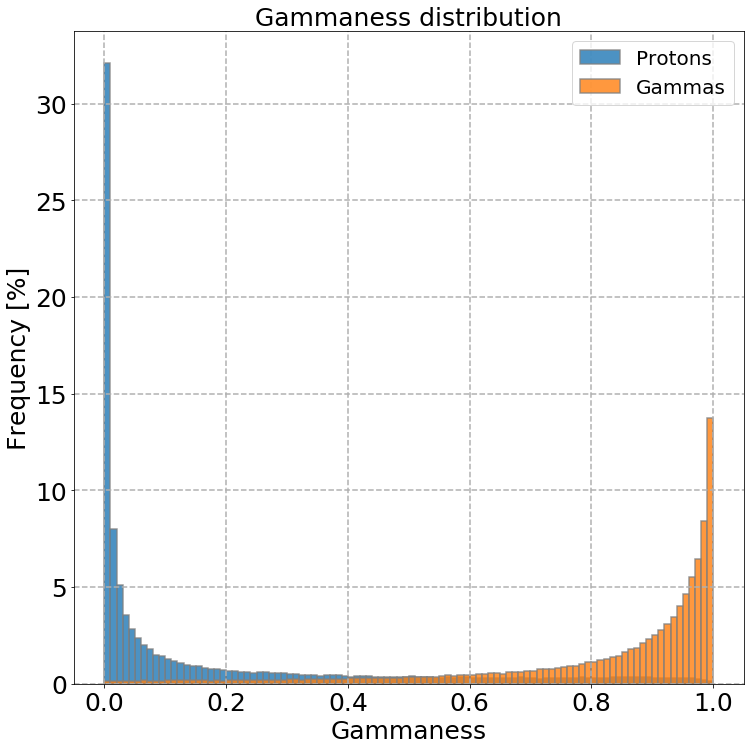

In [9]:
    df = pd.read_csv("VGG16_13_0.88753_0.86502.h5_test.csv")
    df_protons = df[df['GroundTruth'] == 0]
    df_gammas = df[df['GroundTruth'] == 1]
    fig = plt.figure(figsize=(12,12))
    #ax.plot(fp / n_test_protons, label="Protons")
    ax = plt.axes()
    ax.hist(df_protons['Predicted'], bins=100, density=True, label='Protons', alpha = 0.8, edgecolor='gray', linewidth=1.5)
    #ax.plot(fn / n_test_gammas, label="Gammas")
    ax.hist(df_gammas['Predicted'], bins=100, density=True, label='Gammas', alpha=0.8, edgecolor='gray', linewidth=1.5)
    ax.set_title('Gammaness distribution', fontsize=25)
    ax.set_xlabel('Gammaness', fontsize=25)
    ax.set_ylabel('Frequency [%]', fontsize=25)
    # ax.set_xlim(0, 100)
    #ax.set_ylim(top=100)
    #ax.set_yscale('log')
    ax.legend(loc='upper right', fontsize=20)
    ax.grid(b=True, which='major', linestyle='--', lw=1.5)
    ax.grid(b=True, which='minor', linestyle='--', lw=1)
    ax.tick_params(labelsize=25)
    #ax.legend(borderaxespad=0.)
    plt.show()

    #fig.suptitle(r'ROC and $\zeta$ distribution')

    fig.savefig('/mnt/Dati/CTA/PRESENTATION/fig/separation.png', format='png', bbox_inches="tight")#, transparent=False)

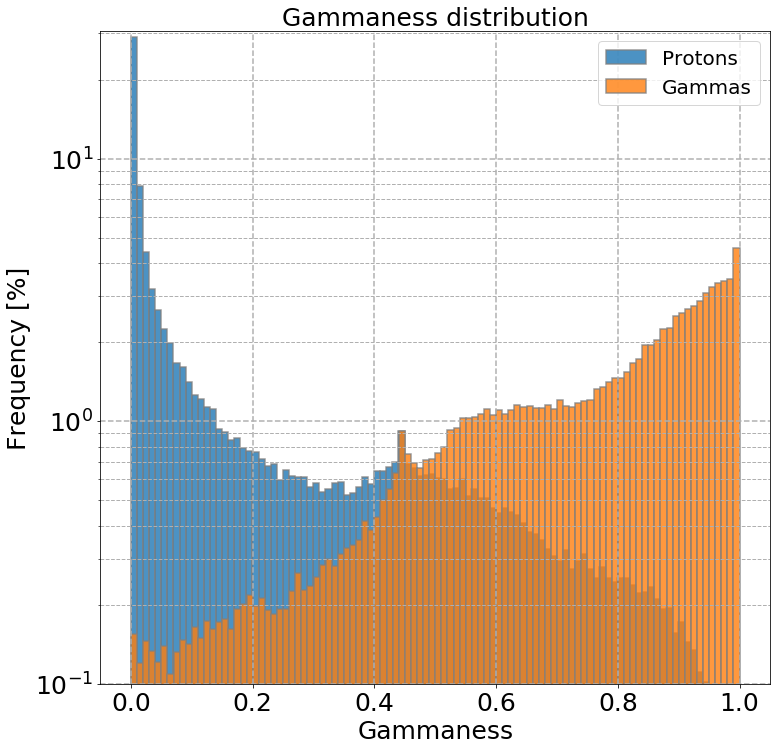

In [10]:
df = pd.read_pickle(files['separation']['Midcut'])
df_protons = df[df['class'] == 0]
df_gammas = df[df['class'] == 1]
fig = plt.figure(figsize=(12,12))
#ax.plot(fp / n_test_protons, label="Protons")
ax = plt.axes()
ax.hist(df_protons['gammaness'], bins=100, density=True, label='Protons', alpha = 0.8, edgecolor='gray', linewidth=1.5)
#ax.plot(fn / n_test_gammas, label="Gammas")
ax.hist(df_gammas['gammaness'], bins=100, density=True, label='Gammas', alpha=0.8, edgecolor='gray', linewidth=1.5)
ax.set_title('Gammaness distribution', fontsize=25)
ax.set_xlabel('Gammaness', fontsize=25)
ax.set_ylabel('Frequency [%]', fontsize=25)
# ax.set_xlim(0, 100)
ax.set_ylim(bottom = 1e-1)
ax.set_yscale('log')
ax.legend(loc='upper right', fontsize=20)
ax.grid(b=True, which='major', linestyle='--', lw=1.5)
ax.grid(b=True, which='minor', linestyle='--', lw=1)
ax.tick_params(labelsize=25)
#ax.legend(borderaxespad=0.)
plt.show()

#fig.suptitle(r'ROC and $\zeta$ distribution')

fig.savefig('/mnt/Dati/CTA/PRESENTATION/fig/separation.png', format='png', bbox_inches="tight")#, transparent=False)

In [11]:
df

,energy_true,energy_reco,class,gammaness
0,-0.660298,-1.356369,0.0,0.002950
1,-1.186808,-1.892262,0.0,0.088028
2,-1.186808,-0.950830,0.0,0.091457
3,0.318660,-0.452083,0.0,0.193477
4,0.227010,-0.286743,0.0,0.793738
...,...,...,...,...
184063,-1.050977,-0.993073,1.0,0.897903
184064,-1.050977,-0.867738,1.0,0.934739
184065,-1.050977,-1.182133,1.0,0.800898
184066,-1.050977,-1.180587,1.0,0.659951


In [12]:
glearn_dic = {"Lowcut":"Low_cuts", "Midcut":"Mid_cuts", "Midcut":"Mid_cuts"}

### Energy resolution 

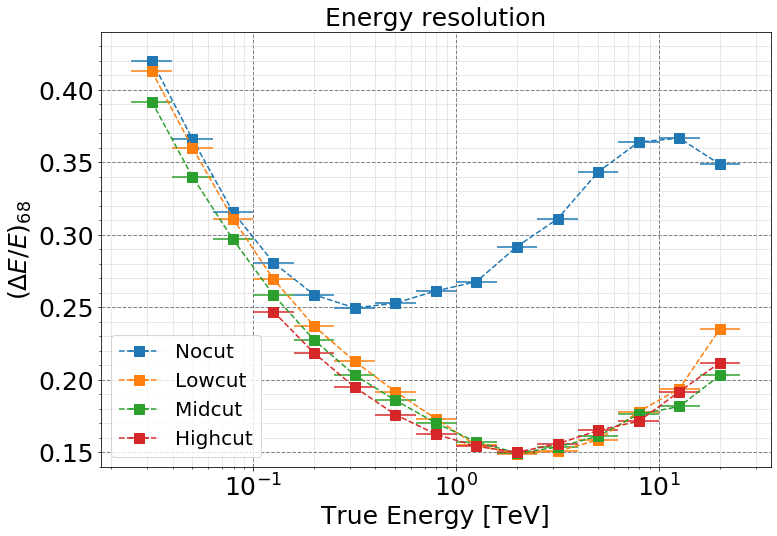

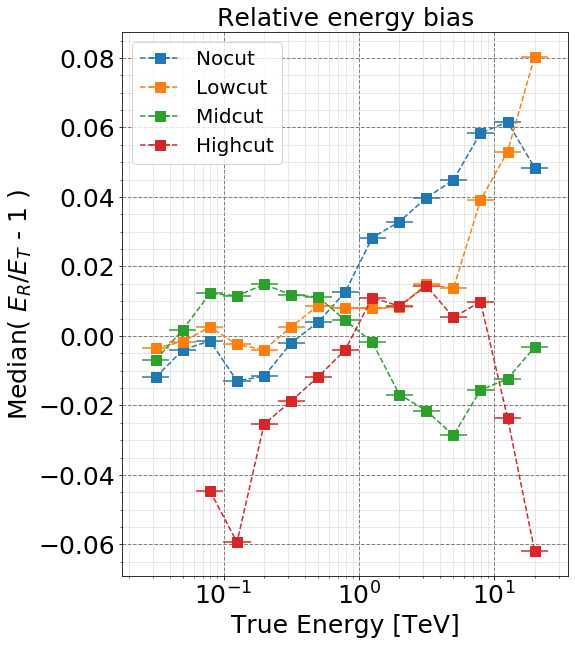

In [13]:
#output_file_name = '/home/pietro/CTA/results/UniPD_results/LSTmono_unipd.h5'
output_file_name = '/home/pietro/CTA/LSTmono_unipd.h5'
data = pd.HDFStore(output_file_name, 'r')

last=-3
for gammatyp in ['pointlike']:
    fig, ax = plt.subplots(1,figsize=(12,8))
    for cut in ['Nocut', 'Lowcut', 'Midcut', 'Highcut']:
        
        for cnn in ['VGG16']:
            energy_data = data['{}/Energy_regression'.format(cnn)]
            Eres = [energy_data['Energy_resolution_{}_{}'.format(gammatyp, cut)]]
            Eres.append(energy_data['Energy_resolution_lower_{}_{}'.format(gammatyp, cut)])
            Eres.append(energy_data['Energy_resolution_upper_{}_{}'.format(gammatyp, cut)])
            Eres = np.array(Eres).T
            if cut == 'Highcut':
                first = 3
                ax.errorbar(E[first:last], Eres[first:last, 0], xerr=(E[first:last] - E_bin[first:last][:-1], E_bin[first:last][1:] - E[first:last]),
                label = '{}'.format(cut), fmt = '--s', markersize=10)
                #ax.fill_between(E[first:last], Eres[first:last, 1], Eres[first:last, 2], alpha=0.3)
            else:
                ax.errorbar(E[:last], Eres[:last, 0], xerr=(E[:last] - E_bin[:last][:-1], E_bin[:last][1:] - E[:last]),
                label = '{}'.format(cut), fmt = '--s', markersize=10)
                #ax.fill_between(E[:last], Eres[:last][:, 1], Eres[:last][:, 2], alpha=0.3)
            
    # Scale, labels and title
    ax.set_ylabel(r"$(\Delta E/E)_{68}$",fontsize=25)
 
    ax.set_ybound(0.14,0.44)
    #ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7])
    ax.set_xlabel("True Energy [TeV]",fontsize=25)
    ax.set_xscale('log')
    #ax.set_xbound(0.02, 30)
    ax.set_title('Energy resolution',fontsize=25)
    ax.tick_params(labelsize=25)

    #major and minor grid lines
    plt.grid(b=True, which='major', color='gray', linestyle='--', lw=1.)
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='silver', ls='--', lw=0.5)

    ax.legend(fontsize=20)
    #ax.text(0.5, 0.7, 'Preliminary', fontsize=58, alpha=0.5, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    plt.savefig("/home/pietro/CTA/results/cuts_before/regression/energyresolution_{}gammas.png".format(gammatyp))
    plt.savefig("/home/pietro/CTA/PRESENTATION/fig/energyresolution_{}gammas.pdf".format(gammatyp), bbox_inches="tight")
    plt.savefig("/home/pietro/CTA/PRESENTATION/fig/energyresolution_{}gammas.png".format(gammatyp), bbox_inches="tight")


    plt.show()
    
    output_file_name = '/home/pietro/CTA/LSTmono_unipd.h5'
data = pd.HDFStore(output_file_name, 'r')

for gammatyp in ['pointlike']:
    fig, ax = plt.subplots(1,figsize=(8,10))
    for cut in ['Nocut', 'Lowcut', 'Midcut', 'Highcut']:
        
        for cnn in ['VGG16']:
            if cut == "Highcut":
                energy_data = data['{}/Energy_regression'.format(cnn)]
                Ebias = energy_data['Energy_bias_{}_{}'.format(gammatyp, cut)]
                ax.errorbar(E[2:last], Ebias[2:last], xerr=(E[2:last] - E_bin[2:last][:-1], E_bin[2:last][1:] - E[2:last]), label = '{}'.format(cut), fmt = '--s', markersize=10)
            else:
                energy_data = data['{}/Energy_regression'.format(cnn)]
                Ebias = energy_data['Energy_bias_{}_{}'.format(gammatyp, cut)]
                ax.errorbar(E[:last], Ebias[:last], xerr=(E[:last] - E_bin[:last][:-1], E_bin[:last][1:] - E[:last]), label = '{}'.format(cut), fmt = '--s', markersize=10)
            
    # Scale, labels and title
    #ax.set_ybound(-0.1,0.1)
    #ax.set_yticks([-0.3,-0.25,-0.2,-0.15,-0.1,-0.05,0.0,0.05,0.1,0.15])
    ax.set_ylabel("Median( $E_{R}/E_{T}$ - 1 )",fontsize=25)
    ax.set_xlabel("True Energy [TeV]",fontsize=25)
    ax.set_xscale('log')
    ax.set_title('Relative energy bias', fontsize=25)
    ax.tick_params(labelsize=25)
    
    #major and minor grid lines
    plt.grid(b=True, which='major', color='gray', linestyle='--', lw=1.)
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='silver', ls='--', lw=0.5)

    ax.legend(loc='upper left',fontsize=20)
    #ax.text(0.5, 0.2, 'Preliminary', fontsize=58, alpha=0.5, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    plt.savefig("/home/pietro/CTA/results/cuts_before/regression/energybias_{}gammas.png".format(gammatyp))
    plt.savefig("/home/pietro/CTA/PRESENTATION/fig/energybias_{}gammas.pdf".format(gammatyp), bbox_inches="tight")
    plt.savefig("/home/pietro/CTA/PRESENTATION/fig/energybias_{}gammas.png".format(gammatyp), bbox_inches="tight")
    plt.show()

data.close()


In [14]:
rf_path = "../RF_lstchain_20200706_v0.5.2_local_no_gammaness_cut.h5"
#rf_path = "../RF_lstchain_20200527_v0.5.1_neighbor_no_gammaness_cut.h5"
rfile = h5py.File(rf_path)
rf_lc = rfile["Low_Cuts"]
rf_mc = rfile["Mid_Cuts"]
rf_hc = rfile["High_Cuts"]
rf_reso = {}

#### ENERGY #####
rf_reso['energy'] = {}
rf_reso['direction'] = {}
##### LOW CUT #####
emylc = []
for x in rf_lc['energy_res'][:]:
    emylc.append(x[0])
emylc
mylc = []
for x in rf_lc['angular_res'][:]:
    mylc.append(x[0]*180/np.pi)
mylc

rf_reso['energy']['Lowcut'] = emylc
rf_reso['direction']['Lowcut'] = mylc
##### MID CUT #####
emylc = []
for x in rf_mc['energy_res'][:]:
    emylc.append(x[0])
emylc
mylc = []
for x in rf_mc['angular_res'][:]:
    mylc.append(x[0]*180/np.pi)
mylc

rf_reso['energy']['Midcut'] = emylc
rf_reso['direction']['Midcut'] = mylc
##### high cut #####
emylc = []
for x in rf_hc['energy_res'][:]:
    emylc.append(x[0])
emylc
mylc = []
for x in rf_hc['angular_res'][:]:
    mylc.append(x[0]*180/np.pi)
mylc

rf_reso['energy']['Highcut'] = emylc
rf_reso['direction']['Highcut'] = mylc

/home/pietro/miniconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide


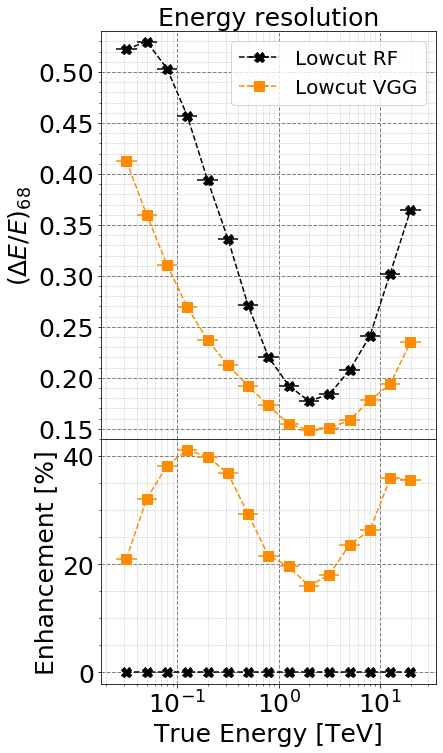

/home/pietro/miniconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide


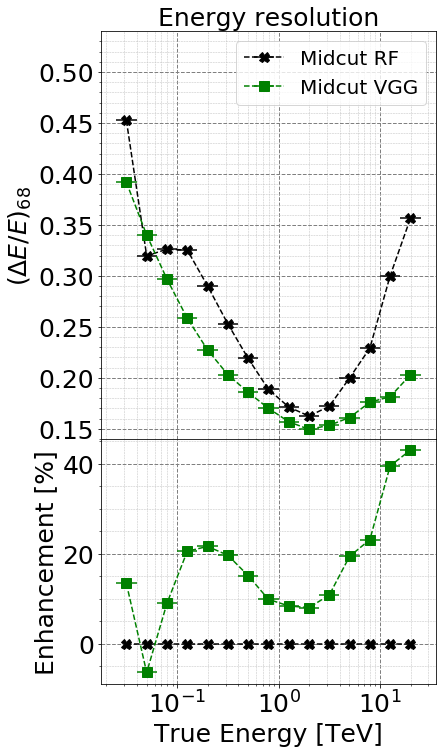

/home/pietro/miniconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/home/pietro/miniconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


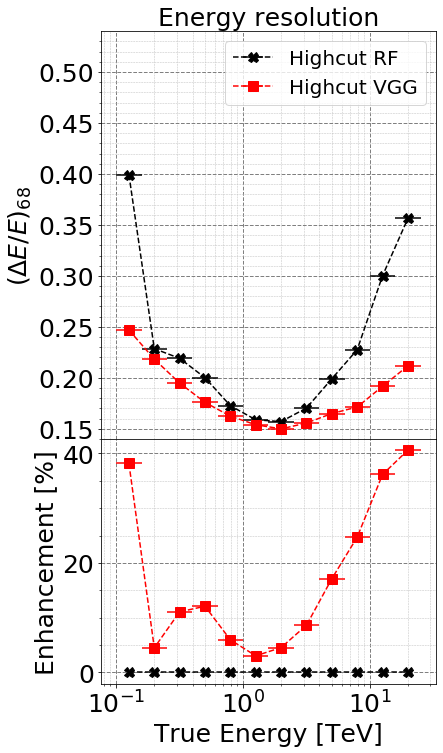

In [15]:
#output_file_name = '/home/pietro/CTA/results/UniPD_results/LSTmono_unipd.h5'
output_file_name = '/home/pietro/CTA/LSTmono_unipd.h5'
data = pd.HDFStore(output_file_name, 'r')
color = {'Lowcut':'darkorange', 'Midcut':'green', 'Highcut':'red'}

last=-3
feature = 'energy'
for gammatyp in ['pointlike']:
    for i, cut in enumerate(['Lowcut', 'Midcut', 'Highcut']):
        fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 12), sharex=True, gridspec_kw={'hspace': 0,'height_ratios': [2.5, 1.5]})
        for cnn in ['VGG16']:
            ax = axs[0]
            energy_data = data['{}/Energy_regression'.format(cnn)]
            Eres = [energy_data['Energy_resolution_{}_{}'.format(gammatyp, cut)]]
            Eres.append(energy_data['Energy_resolution_lower_{}_{}'.format(gammatyp, cut)])
            Eres.append(energy_data['Energy_resolution_upper_{}_{}'.format(gammatyp, cut)])
            Eres = np.array(Eres).T
        first = 0
        if cut == 'Highcut':
            first = 3
        ax.errorbar(E[first:last], rf_reso[feature][cut][first:last], xerr=(E[first:last] - E_bin[first:last][:-1], E_bin[first:last][1:] - E[first:last]),label = "{} RF".format(cut), fmt = '--X', color='black', markersize=10)
        ax.errorbar(E[first:last], Eres[first:last, 0], xerr=(E[first:last] - E_bin[first:last][:-1], E_bin[first:last][1:] - E[first:last]),
        label = '{} VGG'.format(cut), fmt = '--s', markersize=10, color=color[cut])
        
        #ax.fill_between(E[first:last], Eres[first:last, 1], Eres[first:last, 2], alpha=0.3)
        # Scale, labels and title
        ax.set_ylabel(r"$(\Delta E/E)_{68}$",fontsize=25)
     
        ax.set_ybound(0.14,0.54)
        #ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7])
        #ax.set_xlabel("True Energy [TeV]",fontsize=25)
        ax.set_xscale('log')
        ax.set_xbound(0.02, 30)
        ax.set_title('Energy resolution',fontsize=25)
        ax.tick_params(labelsize=25)
    
        #major and minor grid lines
        ax.grid(b=True, which='major', color='gray', alpha=1, linestyle='--', lw=1.)
        ax.minorticks_on()
        ax.grid(b=True, which='minor', color='silver', alpha=1, ls='--', lw=0.5)
    
        ax.legend(fontsize=20)
        ######################################### ax 1 #######################
        ax = axs[1]
        ax.set_xlabel("True Energy [TeV]",fontsize=25)
        ax.set_ylabel("Enhancement [%]",fontsize=25)
        ax.set_xscale('log')
        #ax.set_xlim(0.02, 30)
        ax.tick_params(labelsize=25)
        #ax.legend()
        #major and minor grid lines
        ax.grid(b=True, which='major', color='gray', linestyle='--', lw=1.)
        ax.minorticks_on()
        ax.grid(b=True, which='minor', color='silver', ls='--', lw=0.5)
        #ax.plot([min(E[first:last]), max(E[first:last])], [0,0], lw=3, linestyle = '--' )
        ax.errorbar(E[first:last], [0]*len(E[first:last]), fmt="--X", markersize=10, color="black")
        #perc = (rf_reso[feature][cut]/Eres[:,0] -1)*100
        perc = (1 - Eres[:,0]/rf_reso[feature][cut])*100
        ax.errorbar(E[first:last], perc[first:last], xerr=(E[first:last] - E_bin[first:last][:-1], E_bin[first:last][1:] - E[first:last]), label = 'VGG13: mid-cut', fmt = '--s', lw=1.5, markersize=10, color=color[cut])

        
        #ax.text(0.5, 0.7, 'Preliminary', fontsize=58, alpha=0.5, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    
        plt.savefig("/home/pietro/CTA/results/cuts_before/regression/VGG_RF_comparison_{}_energy.pdf".format(gammatyp))
        plt.savefig("/home/pietro/CTA/PRESENTATION/fig/VGG_RF_comparison_{}_energy.pdf".format(cut), bbox_inches="tight")
        plt.savefig("/home/pietro/CTA/PRESENTATION/fig/VGG_RF_comparison_{}_energy.png".format(cut), bbox_inches="tight")


        plt.show()

data.close()

### Energy bias

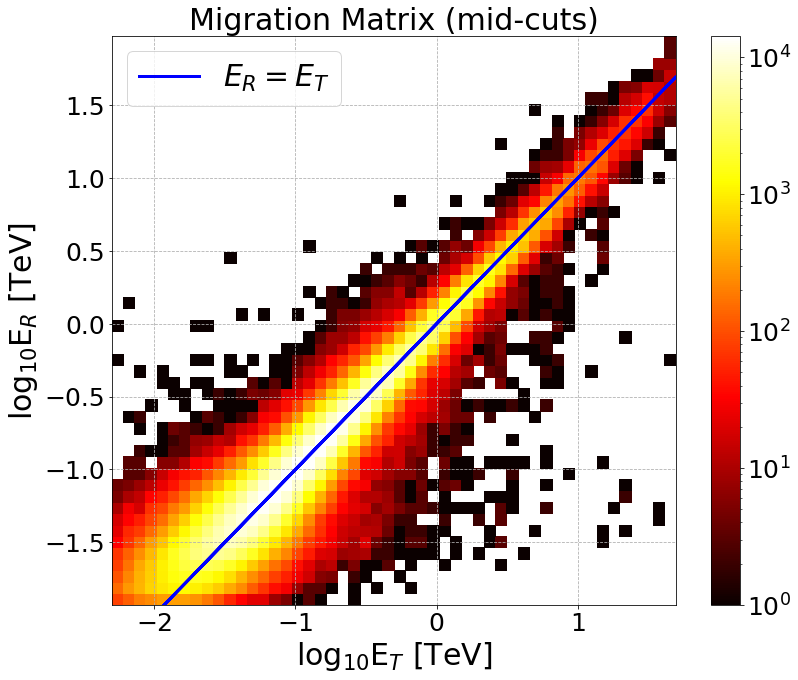

In [16]:
from matplotlib.colors import LogNorm
import matplotlib
fsize=25
cmap = matplotlib.cm.get_cmap('hot', 256)
matplotlib.rcParams.update({'font.size': fsize})
matplotlib.rcParams.update({'axes.labelsize': fsize})
df = pd.read_pickle(files["regression"]["Midcut"])
fig = plt.figure(figsize=(12,10))
lim_max = max(max(df['energy_reco']), max(df['energy_true']))
lim_min = min(min(df['energy_reco']), min(df['energy_true']))
hE = plt.hist2d(df['energy_true'], df['energy_reco'], bins=50, cmap=cmap, norm=LogNorm())#, range=[[lim_min,lim_max],[lim_min,lim_max]])
plt.colorbar(hE[3])
plt.ylabel('$\log_{10}$E$_R$ [TeV]', fontsize=30)
plt.xlabel('$\log_{10}$E$_T$ [TeV]', fontsize=30)
plt.plot(df['energy_true'], df['energy_true'], linestyle="-", lw=3, color='blue', label="$E_R = E_T$")
plt.legend(loc="upper left", fontsize=30)
plt.grid(b=True, which="minor", linestyle='-')
plt.title('Migration Matrix (mid-cuts)')
plt.tight_layout()
plt.grid(ls='--')
plt.savefig('/mnt/Dati/CTA/PRESENTATION/fig/migration_matrix.pdf', format='pdf', bbox_inches="tight")
plt.savefig('/mnt/Dati/CTA/PRESENTATION/fig/migration_matrix.png', format='png', bbox_inches="tight")

In [17]:
print(E_bin[:-3])
print(E)

[2.51000000e-02 3.97824795e-02 6.30536127e-02 9.99374126e-02
 1.58396736e-01 2.51052387e-01 3.97907826e-01 6.30667727e-01
 9.99582707e-01 1.58429795e+00 2.51104784e+00 3.97990874e+00
 6.30799355e+00 9.99791332e+00 1.58462861e+01 2.51157193e+01]
[3.15996873e-02 5.00842196e-02 7.93814519e-02 1.25816374e-01
 1.99413838e-01 3.16062825e-01 5.00946728e-01 7.93980197e-01
 1.25842633e+00 1.99455458e+00 3.16128791e+00 5.01051281e+00
 7.94145910e+00 1.25868898e+01 1.99497086e+01 3.16194771e+01
 5.01155857e+01 7.94311658e+01]


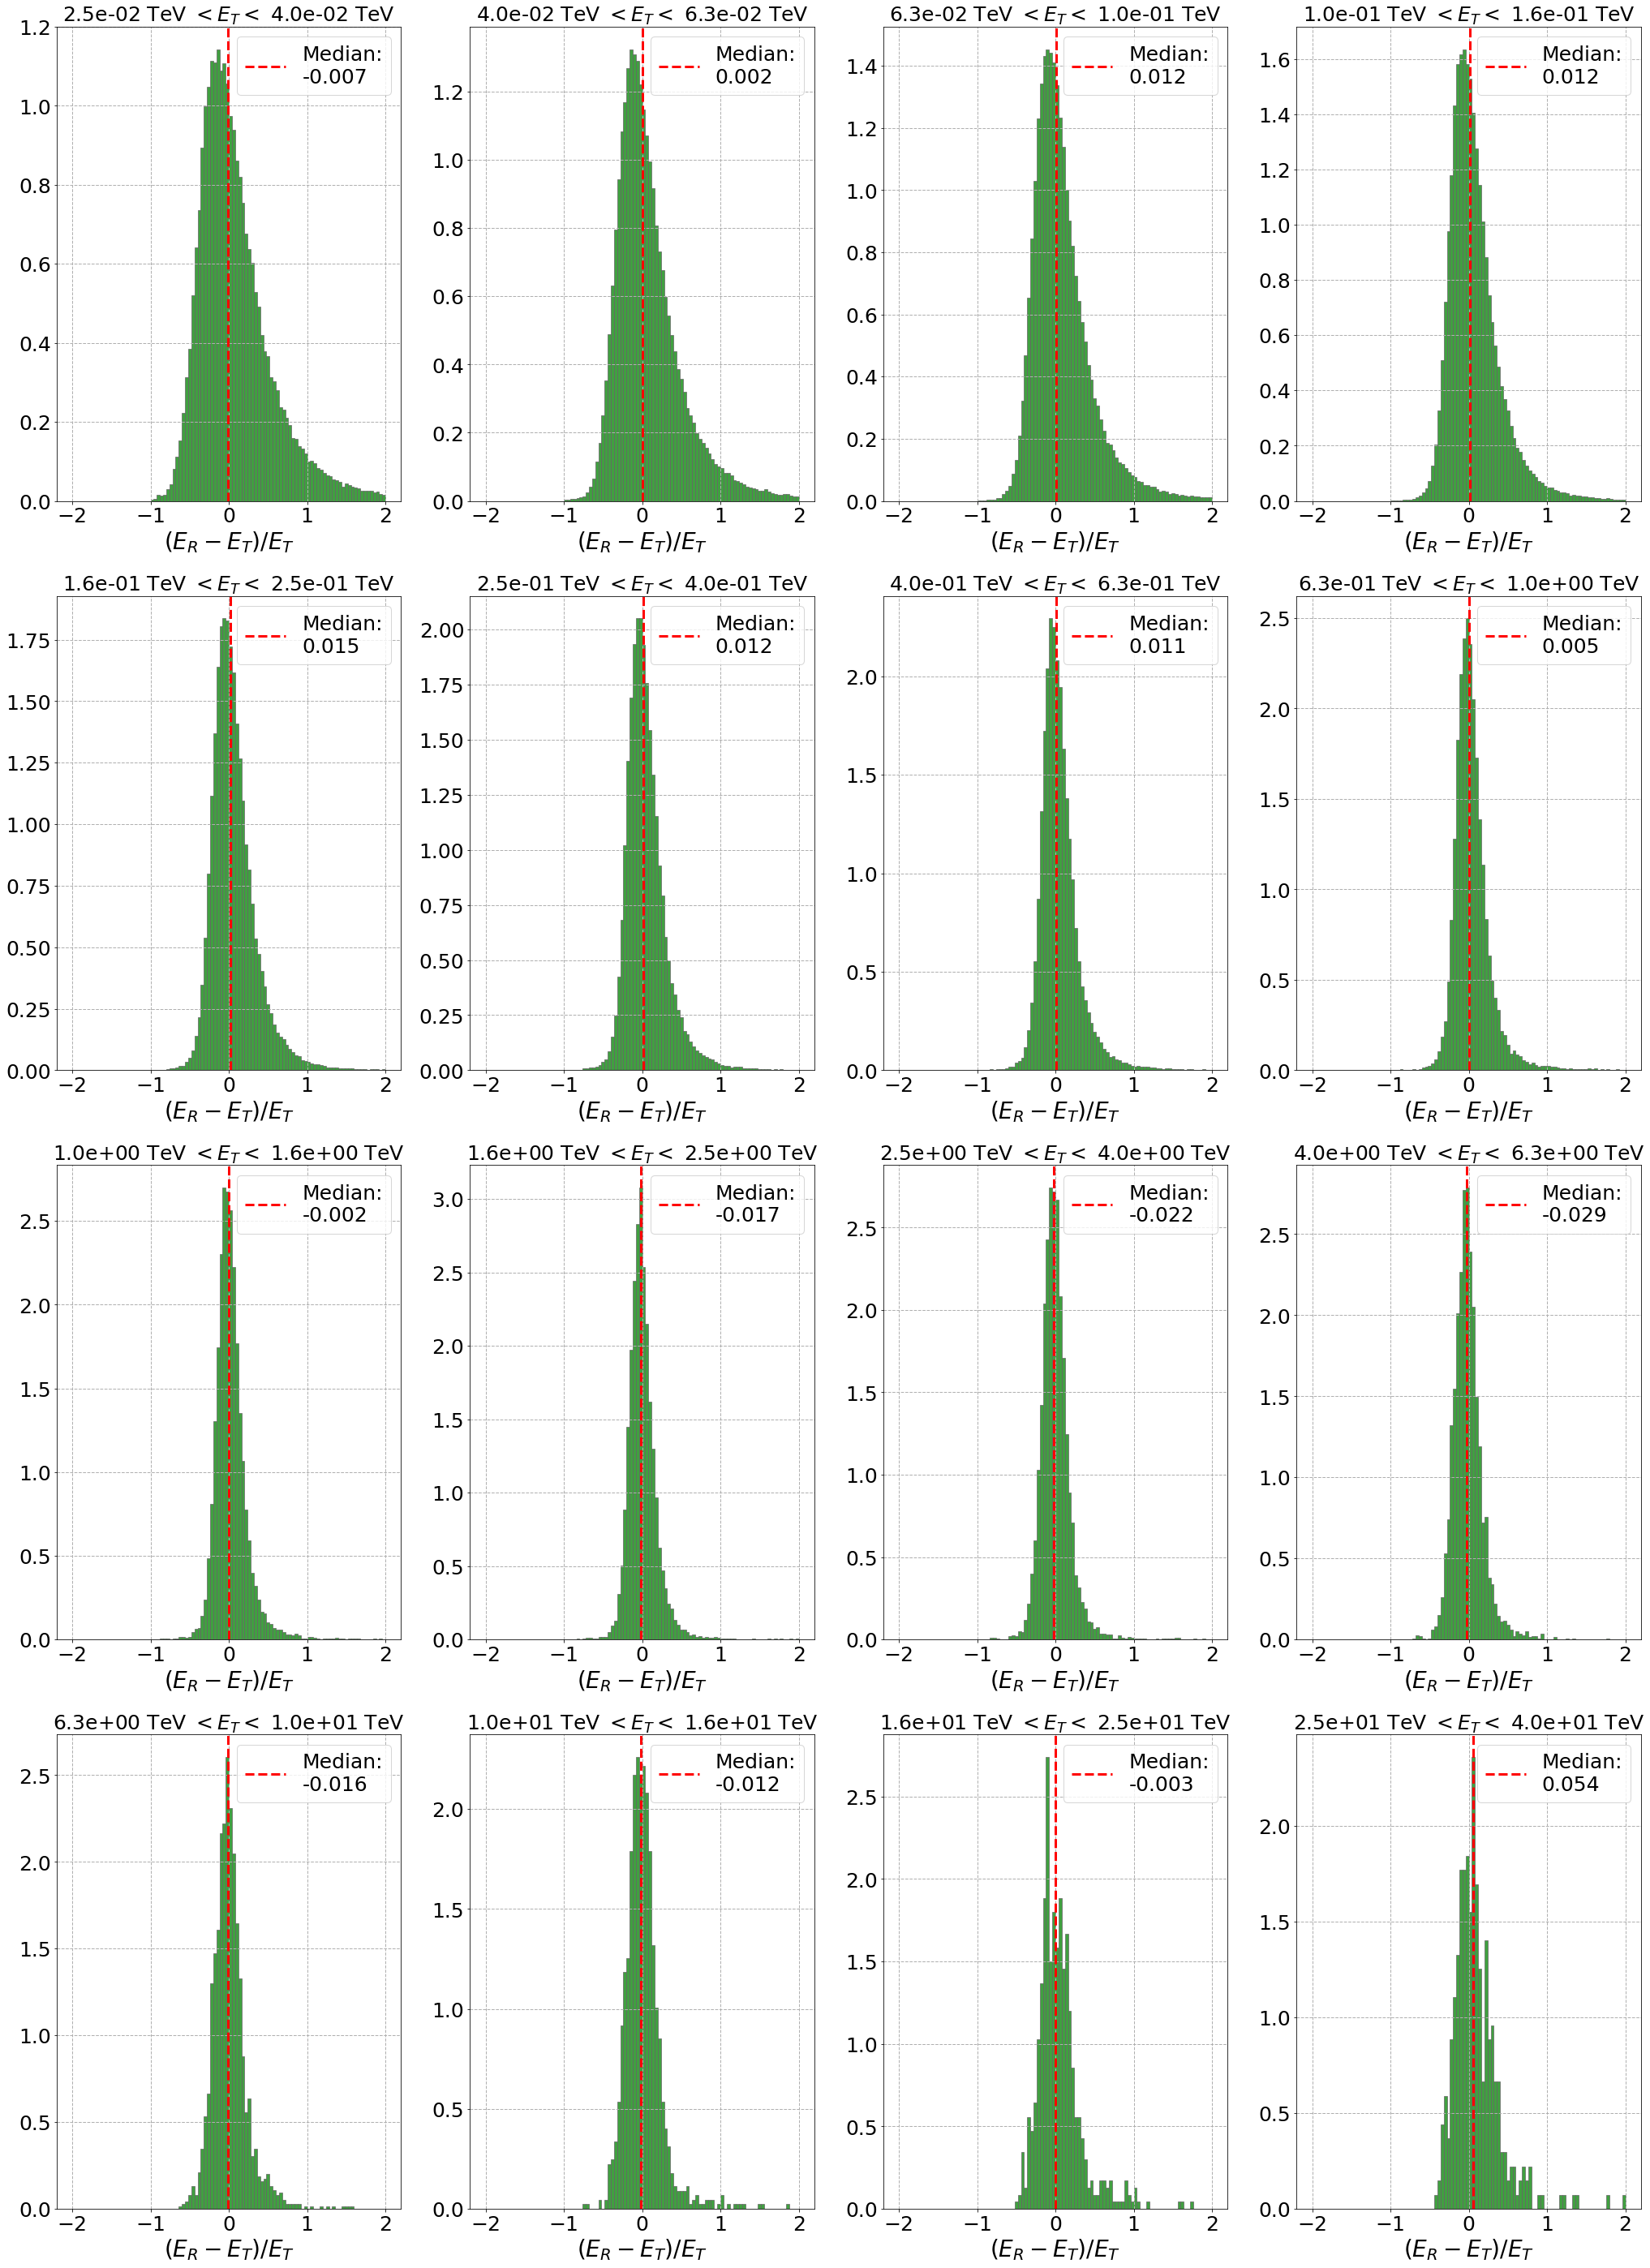

In [18]:
cut = "Midcut"
df = pd.read_pickle(files["regression"][cut])
############## HISTOGRAMS ########################
n_rows = 4 # how many rows figures
n_cols = 4 # how many cols figures
n_figs = n_rows * n_cols
edges = E_bin[:n_figs+1] #np.linspace(np.log10(2.51e-02), np.log10(2.51157193e+01), n_figs + 1)
#edges = np.power(10, edges)


#edges = np.linspace(min(df['energy_true']), max(df['energy_true']), n_figs + 1)
#edges = np.array([-2.,-1.,0.,1.,2.])
df['energy_true'] = np.power(10, df['energy_true'])
df['energy_reco'] = np.power(10, df['energy_reco'])
mus = np.array([]) # saranno le medie del fit gaussiano
sigmas = np.array([]) # saranno le sigma del fit gaussiano

# print('Edges: ', edges)
fs=35
fig = plt.figure(figsize=(fs, fs*1.414)) #fs*np.sqrt(2)))

fsize = 28
#plt.suptitle('Histograms - Energy reconstruction', fontsize=30)
for i in range(n_rows):
    for j in range(n_cols):
        # df with ground truth between edges
        edge1 = edges[n_cols * i + j]
        edge2 = edges[n_cols * i + j + 1]
        # print('\nEdge1: ', edge1, ' Idxs: ', n_cols * i + j)
        # print('Edge2: ', edge2, ' Idxs: ', n_cols * i + j + 1)
        dfbe = df[(df['energy_reco'] >= edge1) & (df['energy_reco'] < edge2)]
        # histogram
        subplot = plt.subplot(n_rows, n_cols, n_cols * i + j + 1)
        difE = (-1 + dfbe['energy_reco']/dfbe['energy_true'])
        median = np.median(difE)
        
        
        xrange = (-2,2)
        n, bins, patches = plt.hist(difE, 100, density=1, alpha=0.75, range=xrange, color="green",edgecolor='dimgray')
        plt.axvline(median, color='red', linestyle='dashed', linewidth=3, label='Median:\n{:.3f}'.format(median))

        '''
        if i !=0 or j !=0:
            mu, sigma= norm.fit(section)
            mus = np.append(mus, mu)
            sigmas = np.append(sigmas, sigma)
            y = norm.pdf(bins, mu, sigma)
            plt.plot(bins, y, 'r--', linewidth=2)
        '''

        plt.xlabel('$( E_{R} - E_{T} ) / E_{T}$', fontsize=fsize)
        # plt.figtext(0.15, 0.9, 'Mean: ' + str(round(mu, 4)), fontsize=10)
        # plt.figtext(0.15, 0.85, 'Std: ' + str(round(sigma, 4)), fontsize=10)
        plt.grid(linestyle="--", linewidth=1)
        plt.legend()
        plt.title("{:.1e} TeV $< E_T < $ {:.1e} TeV".format(edge1, edge2), fontsize=fsize-3)#  Decimal(str(np.power(10, edge1))), Decimal(str(np.power(10, edge2)))  ), fontsize=20   )
    plt.savefig('/mnt/Dati/CTA/PRESENTATION/fig/{}_histograms_energy.pdf'.format(cut), format='pdf', transparent=False, bbox_inches="tight")
    plt.savefig('/mnt/Dati/CTA/PRESENTATION/fig/{}_histograms_energy.png'.format(cut), format='png', transparent=False, bbox_inches="tight")

0.15041616948596093


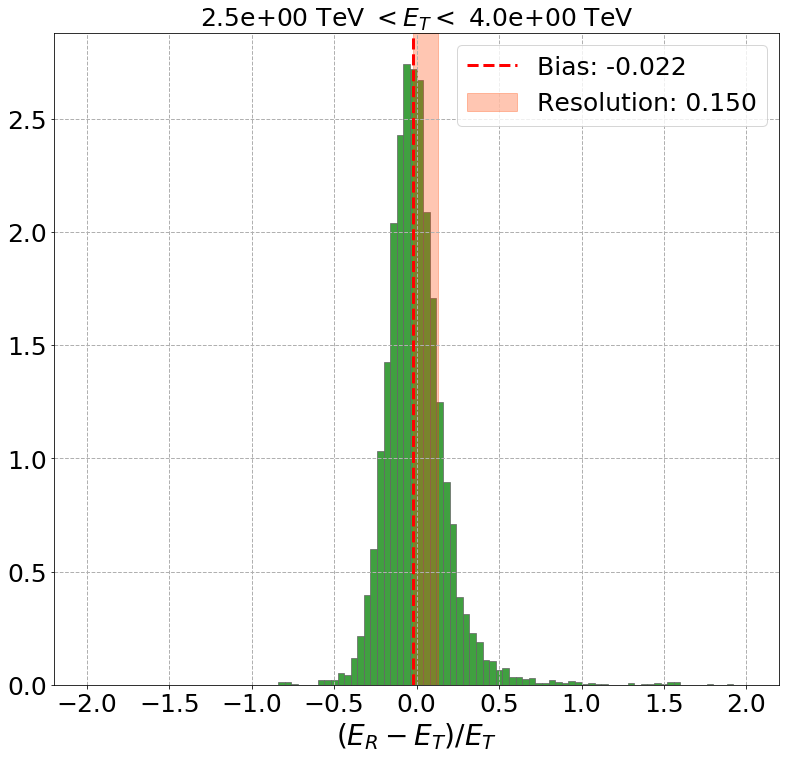

In [19]:
cut = "Midcut"
df = pd.read_pickle(files["regression"][cut])
############## HISTOGRAMS ########################
n_rows = 1 # how many rows figures
n_cols = 1 # how many cols figures
n_figs = n_rows * n_cols
edges = E_bin[10:12] #np.linspace(np.log10(2.51e-02), np.log10(2.51157193e+01), n_figs + 1)
#edges = np.power(10, edges)


#edges = np.linspace(min(df['energy_true']), max(df['energy_true']), n_figs + 1)
#edges = np.array([-2.,-1.,0.,1.,2.])
df['energy_true'] = np.power(10, df['energy_true'])
df['energy_reco'] = np.power(10, df['energy_reco'])
mus = np.array([]) # saranno le medie del fit gaussiano
sigmas = np.array([]) # saranno le sigma del fit gaussiano

# print('Edges: ', edges)
fs=12

fig = plt.figure(figsize=(fs+1,fs))#*np.sqrt(2)))
#fig = plt.figure(figsize=(fs*2,fs))

fsize = 28
#plt.suptitle('Histograms - Energy reconstruction', fontsize=30)
for i in range(n_rows):
    for j in range(n_cols):
        # df with ground truth between edges
        edge1 = edges[n_cols * i + j]
        edge2 = edges[n_cols * i + j + 1]
        # print('\nEdge1: ', edge1, ' Idxs: ', n_cols * i + j)
        # print('Edge2: ', edge2, ' Idxs: ', n_cols * i + j + 1)
        dfbe = df[(df['energy_reco'] >= edge1) & (df['energy_reco'] < edge2)]
        # histogram
        subplot = plt.subplot(n_rows, n_cols, n_cols * i + j + 1)
        difE = (-1 + dfbe['energy_reco']/dfbe['energy_true'])
        median = np.median(difE)
        p_up = np.percentile(difE-median, 84.1)
        p_down = np.percentile(difE-median, 15.9)
        differenza = p_up-p_down
        print(differenza/2)
        
        xrange = (-2,2)
        n, bins, patches = plt.hist(difE, 100, alpha=0.75, density = True, range=xrange, color="green",edgecolor='dimgray')
        plt.axvline(median, color='red', linestyle='dashed', linewidth=3, label='Bias: {:.3f}'.format(median))
        plt.axvspan(median, median+differenza/2, alpha=0.3, color='orangered', label="Resolution: {:.3f}".format(differenza/2))


        #plt.axvline(p_up, color='red', linestyle='dashed', linewidth=3, label='p_up:\n{:.3f}'.format(p_up))
        #plt.axvline(p_down, color='red', linestyle='dashed', linewidth=3, label='p_down:\n{:.3f}'.format(p_down))
        #plt.axvspan(p_down, p_up, alpha=0.3, color='orangered', label="68.2%")
        '''
        if i !=0 or j !=0:
            mu, sigma= norm.fit(section)
            mus = np.append(mus, mu)
            sigmas = np.append(sigmas, sigma)
            y = norm.pdf(bins, mu, sigma)
            plt.plot(bins, y, 'r--', linewidth=2)
        '''

        plt.xlabel('$( E_{R} - E_{T} ) / E_{T}$', fontsize=fsize)
        # plt.figtext(0.15, 0.9, 'Mean: ' + str(round(mu, 4)), fontsize=10)
        # plt.figtext(0.15, 0.85, 'Std: ' + str(round(sigma, 4)), fontsize=10)
        plt.grid(linestyle="--", linewidth=1)
        plt.legend()
        plt.title("{:.1e} TeV $< E_T < $ {:.1e} TeV".format(edge1, edge2), fontsize=fsize-3)#  Decimal(str(np.power(10, edge1))), Decimal(str(np.power(10, edge2)))  ), fontsize=20   )
    #plt.savefig('/mnt/Dati/CTA/PRESENTATION/fig/{}_histogram_energy.pdf'.format(cut), format='pdf', transparent=False, bbox_inches="tight")
    plt.savefig('/mnt/Dati/CTA/PRESENTATION/fig/{}_histogram_energy_ONLYONE.png'.format(cut), format='png', transparent=False, bbox_inches="tight")

<Figure size 576x814.587 with 0 Axes>

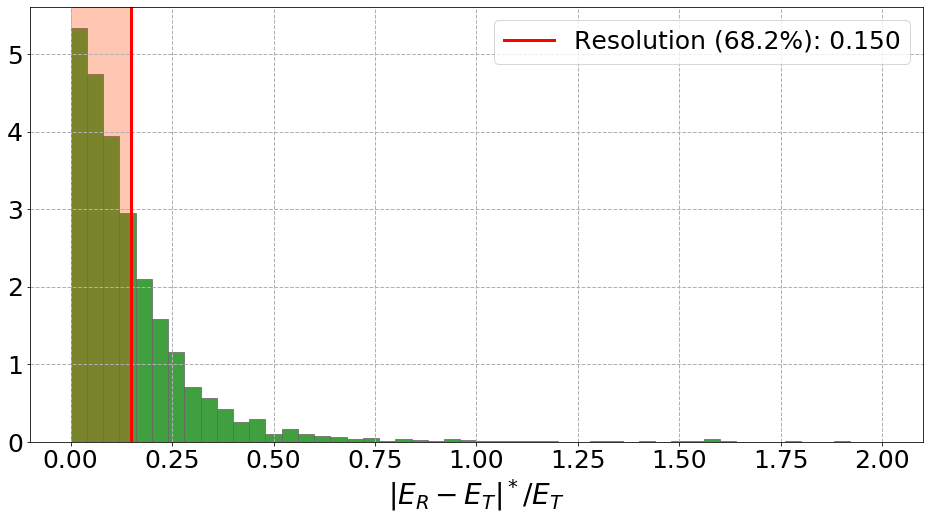

In [20]:
cut = "Midcut"
df = pd.read_pickle(files["regression"][cut])
############## HISTOGRAMS ########################
n_rows = 1 # how many rows figures
n_cols = 1 # how many cols figures
n_figs = n_rows * n_cols
#edges = E_bin[10:12] #np.linspace(np.log10(2.51e-02), np.log10(2.51157193e+01), n_figs + 1)
#edges = np.power(10, edges)
edges = E_bin[10:12]

#edges = np.linspace(min(df['energy_true']), max(df['energy_true']), n_figs + 1)
#edges = np.array([-2.,-1.,0.,1.,2.])
df['energy_true'] = np.power(10, df['energy_true'])
df['energy_reco'] = np.power(10, df['energy_reco'])
mus = np.array([]) # saranno le medie del fit gaussiano
sigmas = np.array([]) # saranno le sigma del fit gaussiano

# print('Edges: ', edges)
fs=8
fig = plt.figure(figsize=(fs,fs*np.sqrt(2)))
fig = plt.figure(figsize=(fs*2,fs))

fsize = 28
#plt.suptitle('Histograms - Energy reconstruction', fontsize=30)
for i in range(n_rows):
    for j in range(n_cols):
        # df with ground truth between edges
        edge1 = edges[n_cols * i + j]
        edge2 = edges[n_cols * i + j + 1]
        # print('\nEdge1: ', edge1, ' Idxs: ', n_cols * i + j)
        # print('Edge2: ', edge2, ' Idxs: ', n_cols * i + j + 1)
        dfbe = df[(df['energy_reco'] >= edge1) & (df['energy_reco'] < edge2)]
        # histogram
        subplot = plt.subplot(n_rows, n_cols, n_cols * i + j + 1)
        difE = (-1 + dfbe['energy_reco']/dfbe['energy_true'])
        median=np.median(difE)
        perc68 = np.percentile(abs(difE-median), 68.2)
        
        
        xrange = (0,2)
        n, bins, patches = plt.hist(difE-median, 50, density=1, alpha=0.75, range=xrange, color="green",edgecolor='dimgray')
        plt.axvline(perc68, color='red', linestyle='-', linewidth=3, label='Resolution (68.2%): {:.3f}'.format(perc68))
        plt.axvspan(0, perc68, alpha=0.3, color='orangered')
        '''
        if i !=0 or j !=0:
            mu, sigma= norm.fit(section)
            mus = np.append(mus, mu)
            sigmas = np.append(sigmas, sigma)
            y = norm.pdf(bins, mu, sigma)
            plt.plot(bins, y, 'r--', linewidth=2)
        '''

        plt.xlabel('$| E_{R} - E_{T} |^* / E_{T}$', fontsize=fsize)
        # plt.figtext(0.15, 0.9, 'Mean: ' + str(round(mu, 4)), fontsize=10)
        # plt.figtext(0.15, 0.85, 'Std: ' + str(round(sigma, 4)), fontsize=10)
        plt.grid(linestyle="--", linewidth=1)
        plt.legend()
        #plt.title("{:.1e} TeV $< E_T < $ {:.1e} TeV".format(edge1, edge2), fontsize=fsize-3)#  Decimal(str(np.power(10, edge1))), Decimal(str(np.power(10, edge2)))  ), fontsize=20   )
    #plt.savefig('/mnt/Dati/CTA/PRESENTATION/fig/{}_histogram_energy.pdf'.format(cut), format='pdf', transparent=False, bbox_inches="tight")
    plt.savefig('/mnt/Dati/CTA/PRESENTATION/fig/{}_histogram_energy_ONLYONE_reso.png'.format(cut), format='png', transparent=False, bbox_inches="tight")

In [21]:
data.close()

### Angular resolution

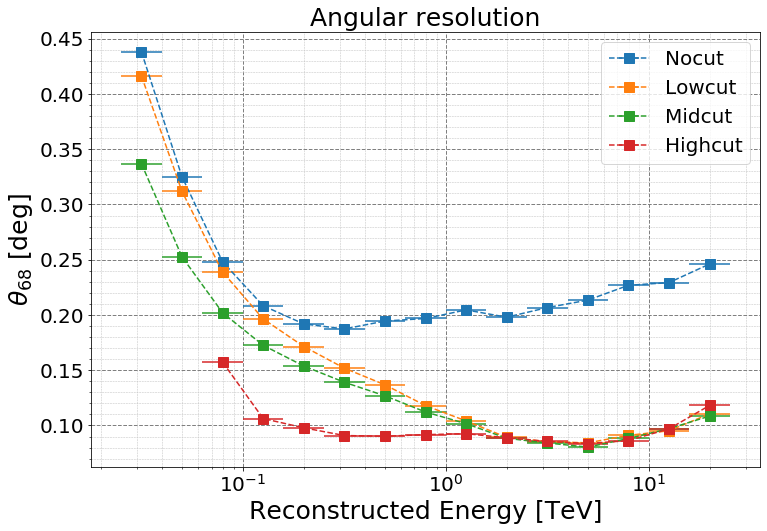

In [22]:
output_file_name = '/home/pietro/CTA/LSTmono_unipd.h5'
rf_path = "../RF_lstchain_20200706_v0.5.2_local_no_gammaness_cut.h5"
data = pd.HDFStore(output_file_name, 'r')
rfile = h5py.File(rf_path)
last=-3
for gammatyp in ['pointlike']:
    fig, ax = plt.subplots(1,figsize=(12,8))
    for cut in ['Nocut', 'Lowcut', 'Midcut', 'Highcut']:
        for cnn in ['VGG16']:
            angular_data = data['{}/ArrivalDirection_regression'.format(cnn)]
            Angres = [angular_data['Angular_resolution_{}_{}'.format(gammatyp, cut)]]
            Angres.append(angular_data['Angular_resolution_lower_{}_{}'.format(gammatyp, cut)])
            Angres.append(angular_data['Angular_resolution_upper_{}_{}'.format(gammatyp, cut)])
            Angres = np.array(Angres).T
             
            if cut == 'Highcut':
                first=2
                ax.errorbar(E[2:last], Angres[2:last][:, 0], xerr=(E[2:last] - E_bin[2:last][:-1], E_bin[2:last][1:] - E[2:last]),
                            label = '{}'.format(cut), fmt = '--s', markersize=10)
                        #yerr=(Angres[2:last][:, 0] - Angres[2:last][:, 1], Angres[2:last][:, 2] - Angres[2:last][:, 0]),
                        
                #ax.fill_between(E[first:last], Angres[first:last, 1], Angres[first:last, 2], alpha=0.3)
            else:
                ax.errorbar(E[:last], Angres[:last][:, 0], xerr=(E[:last] - E_bin[:last][:-1], E_bin[:last][1:] - E[:last]),
                            label = '{}'.format(cut), fmt = '--s', markersize=10)
                        #yerr=(Angres[:last][:, 0] - Angres[:last][:, 1], Angres[:last][:, 2] - Angres[:last][:, 0])
                    
                #ax.fill_between(E[:last], Angres[:last][:, 1], Angres[:last][:, 2], alpha=0.3)
    # Scale, labels and title
    ax.set_ylabel(r'$\theta_{68}$ [deg]',fontsize=25)
    #ax.set_ybound(0.01,0.5)
    #ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7])
    ax.set_xlabel("Reconstructed Energy [TeV]",fontsize=25)
    ax.set_xscale('log')
    ax.set_title('Angular resolution',fontsize=25)

    ax.tick_params(labelsize=20)

    #major and minor grid lines
    plt.grid(b=True, which='major', color='gray', linestyle='--', lw=1.)
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='silver', ls='--', lw=0.5)
    
    if gammatyp == 'diffuse':
        ax.legend(loc='lower right',fontsize=20)
    elif gammatyp == 'pointlike':
        ax.legend(loc='upper right',fontsize=20)
    #ax.text(0.3, 0.8, 'Preliminary', fontsize=58, alpha=0.5, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    plt.savefig("/home/pietro/CTA/results/cuts_before/regression/arrdirresolution_{}gammas.png".format(gammatyp))
    plt.savefig("/home/pietro/CTA/PRESENTATION/fig/arrdirresolution_{}gammas.pdf".format(gammatyp), bbox_inches="tight")
    plt.savefig("/home/pietro/CTA/PRESENTATION/fig/arrdirresolution_{}gammas.png".format(gammatyp), bbox_inches="tight")


    plt.show()
    
data.close()

In [23]:
data.close()

cut = "Midcut"
df = pd.read_pickle(files["regression"][cut])
n_rows = 4 # how many rows figures
n_cols = 4  # how many cols figures
n_figs = n_rows * n_cols
edges = E_bin[:n_figs+1]
#edges = np.logspace(np.log10(min(df['energy_true'])), np.log10(max(df['energy_true'])), n_figs + 1)
theta2_68 = np.array([])
# print('Edges: ', edges)
fs=35
fig = plt.figure(figsize=(fs*1.414, fs)) #fs*np.sqrt(2)))

fsize=26

#plt.suptitle('Histograms - Direction reconstruction', fontsize=30)
df['energy_true'] = np.power(10, df['energy_true'])
df['energy_reco'] = np.power(10, df['energy_reco'])
for i in range(n_rows):
    for j in range(n_cols):
        # df with ground truth between edges
        edge1 = edges[n_cols * i + j]
        edge2 = edges[n_cols * i + j + 1]
        #print(df)
        #print(min(df['energy_reco']))
        dfbe = df[(df['energy_reco'] >= edge1) & (df['energy_reco'] < edge2)]
        # histogram
        subplot = plt.subplot(n_rows, n_cols, n_cols * i + j + 1)
        theta2 = (dfbe['d_alt_true'] - dfbe['d_alt_reco']) ** 2 + (dfbe['d_az_true'] - dfbe['d_az_reco']) ** 2
        # section = theta2[abs(theta2) < 1.5]
        # mu, sigma = norm.fit(section)
        # 68% containement computation
        # total = np.sum(theta2)
        total = len(theta2)
        # theta2_68 = np.append(theta2_68, np.percentile(theta2, 68))
        #hist = np.histogram(theta2, bins=100)
        theta68 = np.percentile(theta2, 68)
        #for k in range(0, len(hist[0]) + 1):
        #    fraction = np.sum(hist[0][:k]) / total
        #    if fraction > 0.68:
        #        print('\nTotal: ', total)
        #        print('0.68 of total:', np.sum(hist[0][:k]))
        #        print('Fraction:', fraction)
        #        theta2_68 = np.append(theta2_68, hist[1][k])
        #        break
        # n, bins, patches = plt.hist(theta2, bins=100, range=(0, hist[1][k]))
        #plt.semilogx()
        n, bins, patches = plt.hist(theta2, bins=100, range=(0,1),edgecolor='gray')
        #n, bins, patches = plt.hist(theta2, bins=250, edgecolor='gray', linewidth=0.1)
        plt.axvline(theta68, color='r', linestyle='dashed', linewidth=3, label=r'$\theta68$ = {:.3f} deg'.format(np.sqrt(theta68)))
        #plt.yscale('log', nonposy='clip')
        # patches[k].set_fc('r')
        # y = norm.pdf(bins, mu, sigma)
        # plt.plot(bins, y, 'r--', linewidth=2)
        plt.grid(linestyle='--')
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.xlabel(r'$\theta^{2}$ [deg$^2$]', fontsize=fsize)
        plt.ylabel('Counts', fontsize=fsize)
        plt.title("{:.1e} TeV $<E_R<${:.1e} TeV".format(edge1, edge2), fontsize=fsize)
        plt.legend(fontsize=fsize)
        #plt.xticks([0,hist[1][k], 0.2, 0.4, 0.6, 0.8, 1.0])
        plt.savefig("/mnt/Dati/CTA/PRESENTATION/fig/theta_squares.pdf", bbox_inches="tight")

[0.39985499 0.59987311]


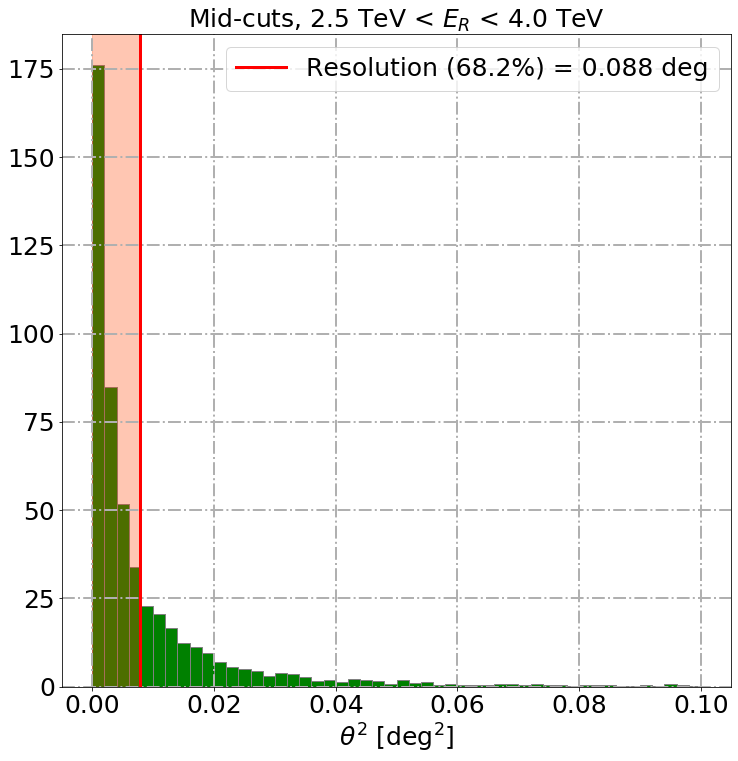

In [24]:
import matplotlib
cut = "Midcut"
df = pd.read_pickle(files["regression"][cut])
n_rows = 1 # how many rows figures
n_cols = 1  # how many cols figures
n_figs = n_rows * n_cols
edges = np.log10(E_bin[10:12])
#edges = np.array([min(min(df['energy_true']),min(df['energy_reco'])), np.log10(50)])
print(edges)
theta2_68 = np.array([])
# print('Edges: ', edges)
fs=12
fig = plt.figure(figsize=(fs, fs)) #fs*np.sqrt(2)))

fsize=25
#matplotlib.rcParams.update({'font.size': fsize-2})
#matplotlib.rcParams.update({'axes.labelsize': fsize-2})

#plt.suptitle('Histograms - Direction reconstruction', fontsize=30)
#df['energy_true'] = np.power(10, df['energy_true'])
#df['energy_reco'] = np.power(10, df['energy_reco'])
for i in range(n_rows):
    for j in range(n_cols):
        # df with ground truth between edges
        edge1 = edges[n_cols * i + j]
        edge2 = edges[n_cols * i + j + 1]
        #print(df)
        #print(min(df['energy_reco']))
        dfbe = df[(df['energy_reco'] >= edge1) & (df['energy_reco'] <= edge2)]
        # histogram
        subplot = plt.subplot(n_rows, n_cols, n_cols * i + j + 1)
        theta2 = (dfbe['d_alt_true'] - dfbe['d_alt_reco']) ** 2 + (dfbe['d_az_true'] - dfbe['d_az_reco']) ** 2
        # section = theta2[abs(theta2) < 1.5]
        # mu, sigma = norm.fit(section)
        # 68% containement computation
        # total = np.sum(theta2)
        total = len(theta2)
        # theta2_68 = np.append(theta2_68, np.percentile(theta2, 68))
        #hist = np.histogram(theta2, bins=100)
        theta68 = np.percentile(theta2, 68)
        #for k in range(0, len(hist[0]) + 1):
        #    fraction = np.sum(hist[0][:k]) / total
        #    if fraction > 0.68:
        #        print('\nTotal: ', total)
        #        print('0.68 of total:', np.sum(hist[0][:k]))
        #        print('Fraction:', fraction)
        #        theta2_68 = np.append(theta2_68, hist[1][k])
        #        break
        # n, bins, patches = plt.hist(theta2, bins=100, range=(0, hist[1][k]))
        #plt.semilogx()
        n, bins, patches = plt.hist(theta2, bins=50, range=(0,0.1), density=True,edgecolor='gray', color='green')
        #n, bins, patches = plt.hist(theta2, bins=250, edgecolor='gray', linewidth=0.1)
        plt.axvline(theta68, color='r', linestyle='-', linewidth=3, label='Resolution (68.2%) = {:.3f} deg'.format((np.sqrt(theta68))))
        plt.axvspan(0, theta68, alpha=0.3, color='orangered')
        #plt.yscale('log', nonposy='clip')
        # patches[k].set_fc('r')
        # y = norm.pdf(bins, mu, sigma)
        # plt.plot(bins, y, 'r--', linewidth=2)
        plt.grid(linestyle='-.', lw=2)
        #plt.xticks(fontsize=15)
        #plt.yticks(fontsize=15)
        plt.xlabel(r'$\theta^{2}$ [deg$^2$]', fontsize=fsize)
        #plt.ylabel('Counts', fontsize=fsize)
        plt.title("Mid-cuts, {:.1f} TeV < $E_R$ < {:.1f} TeV".format(np.power(10,edge1), np.power(10,edge2)), fontsize=fsize)
        plt.legend(fontsize=fsize)
        #plt.xticks([0,hist[1][k], 0.2, 0.4, 0.6, 0.8, 1.0])
        plt.savefig("/mnt/Dati/CTA/PRESENTATION/fig/theta_squares.pdf", bbox_inches="tight")
        plt.savefig("/mnt/Dati/CTA/PRESENTATION/fig/theta_squares.png", bbox_inches="tight")

#######################################################################################################
##################################### CNN RFs COMPARISON #############################################
#######################################################################################################

/home/pietro/miniconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/home/pietro/miniconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


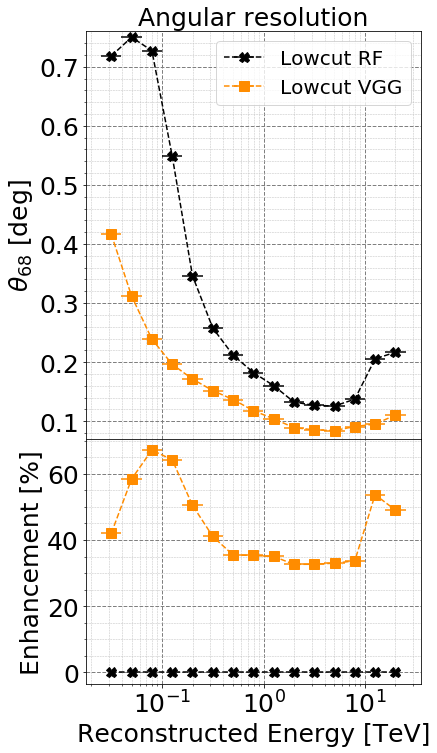

/home/pietro/miniconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/home/pietro/miniconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


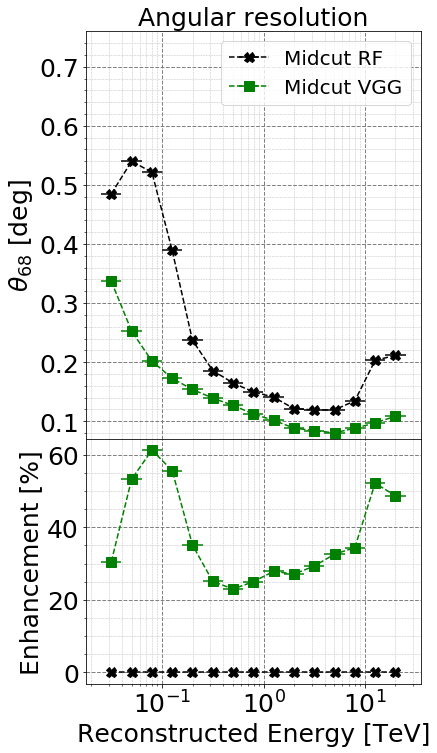

/home/pietro/miniconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/home/pietro/miniconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


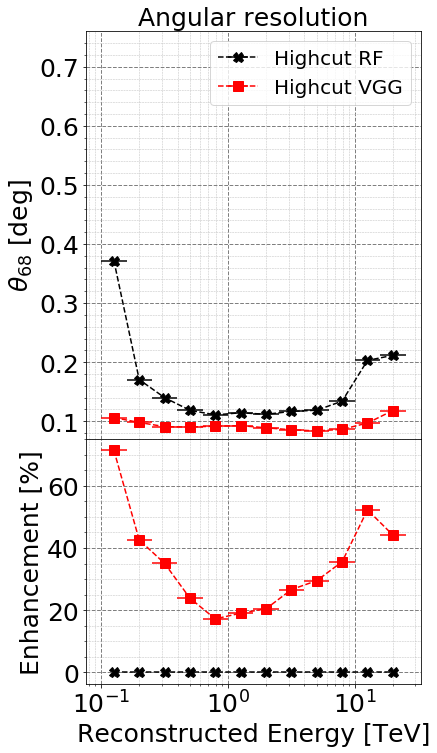

In [25]:
#output_file_name = '/home/pietro/CTA/results/UniPD_results/LSTmono_unipd.h5'
output_file_name = '/home/pietro/CTA/LSTmono_unipd.h5'
data = pd.HDFStore(output_file_name, 'r')
color = {'Lowcut':'darkorange', 'Midcut':'green', 'Highcut':'red'}

last=-3
feature = 'direction'
for gammatyp in ['pointlike']:
    for i, cut in enumerate(['Lowcut', 'Midcut', 'Highcut']):
        fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 12), sharex=True, gridspec_kw={'hspace': 0,'height_ratios': [2.5, 1.5]})
        for cnn in ['VGG16']:
            ax = axs[0]
            angular_data = data['{}/ArrivalDirection_regression'.format(cnn)]
            Angres = [angular_data['Angular_resolution_{}_{}'.format(gammatyp, cut)]]
            Angres.append(angular_data['Angular_resolution_lower_{}_{}'.format(gammatyp, cut)])
            Angres.append(angular_data['Angular_resolution_upper_{}_{}'.format(gammatyp, cut)])
            Angres = np.array(Angres).T
        first = 0
        if cut == 'Highcut':
            first = 3
        ax.errorbar(E[first:last], rf_reso[feature][cut][first:last], xerr=(E[first:last] - E_bin[first:last][:-1], E_bin[first:last][1:] - E[first:last]),label = "{} RF".format(cut), fmt = '--X', color='black', markersize=10)
        ax.errorbar(E[first:last], Angres[first:last, 0], xerr=(E[first:last] - E_bin[first:last][:-1], E_bin[first:last][1:] - E[first:last]),
        label = '{} VGG'.format(cut), fmt = '--s', markersize=10, color=color[cut])
        
        #ax.fill_between(E[first:last], Eres[first:last, 1], Eres[first:last, 2], alpha=0.3)
        # Scale, labels and title
        ax.set_ylabel(r"$\theta_{68}$ [deg]",fontsize=25)
     
        ax.set_ybound(0.07,0.76)
        #ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7])
        #ax.set_xlabel("Reconstructed Energy [TeV]",fontsize=25)
        ax.set_xscale('log')
        ax.set_xbound(0.02, 30)
        ax.set_title('Angular resolution',fontsize=25)
        ax.tick_params(labelsize=25)
    
        #major and minor grid lines
        ax.grid(b=True, which='major', color='gray', linestyle='--', lw=1.)
        ax.minorticks_on()
        ax.grid(b=True, which='minor', color='silver', ls='--', lw=0.5)
    
        ax.legend(fontsize=20)
        ######################################### ax 1 #######################
        ax = axs[1]
        ax.set_xlabel("Reconstructed Energy [TeV]",fontsize=25)
        ax.set_ylabel("Enhancement [%]",fontsize=25)
        ax.set_xscale('log')
        #ax.set_xlim(0.02, 30)
        ax.tick_params(labelsize=25)
        #ax.legend()
        #major and minor grid lines
        ax.grid(b=True, which='major', color='gray', linestyle='--', lw=1.)
        ax.minorticks_on()
        ax.grid(b=True, which='minor', color='silver', ls='--', lw=0.5)
        #ax.plot([min(E[first:last]), max(E[first:last])], [0,0], lw=3, linestyle = '--' )
        ax.errorbar(E[first:last], [0]*len(E[first:last]), fmt="--X", markersize=10, color="black")
        #perc = (rf_reso[feature][cut]/Angres[:,0] -1)*100
        perc = (-Angres[:,0]/rf_reso[feature][cut] +1)*100
        ax.errorbar(E[first:last], perc[first:last], xerr=(E[first:last] - E_bin[first:last][:-1], E_bin[first:last][1:] - E[first:last]), label = 'VGG13: mid-cut', fmt = '--s', lw=1.5, markersize=10, color=color[cut])

        
        #ax.text(0.5, 0.7, 'Preliminary', fontsize=58, alpha=0.5, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    
        plt.savefig("/home/pietro/CTA/results/cuts_before/regression/VGG_RF_comparison_{}_direction.pdf".format(gammatyp))
        plt.savefig("/home/pietro/CTA/PRESENTATION/fig/VGG_RF_comparison_{}_direction.pdf".format(cut), bbox_inches="tight")
        plt.savefig("/home/pietro/CTA/PRESENTATION/fig/VGG_RF_comparison_{}_direction.png".format(cut), bbox_inches="tight")


        plt.show()

data.close()

In [26]:
data = pd.HDFStore(output_file_name, 'r')
cnn = 'VGG16'
gammatyp = 'pointlike'
cut = 'Midcut'
angular_data = data['{}/ArrivalDirection_regression'.format(cnn)]
Angres = [angular_data['Angular_resolution_{}_{}'.format(gammatyp, cut)]]
Angres.append(angular_data['Angular_resolution_lower_{}_{}'.format(gammatyp, cut)])
Angres.append(angular_data['Angular_resolution_upper_{}_{}'.format(gammatyp, cut)])
Angres = np.array(Angres).T
energy_data = data['{}/Energy_regression'.format(cnn)]
Eres = [energy_data['Energy_resolution_{}_{}'.format(gammatyp, cut)]]
Eres.append(energy_data['Energy_resolution_lower_{}_{}'.format(gammatyp, cut)])
Eres.append(energy_data['Energy_resolution_upper_{}_{}'.format(gammatyp, cut)])
Eres = np.array(Eres).T
data.close()

In [27]:
ebin, eres = ctaplot.ana.energy_resolution_per_energy(mc_energy, reco_energy)
ebin, ebias = ctaplot.ana.energy_bias(mc_energy, reco_energy)
ebin, angres = ctaplot.ana.angular_resolution_per_energy(reco_alt, reco_az, mc_alt, mc_az, reco_energy)
print(ebin.shape, angres.shape)

(19,) (18, 3)


In [28]:
import tables
rf_path = "../RF_lstchain_20200706_v0.5.2_local_no_gammaness_cut.h5"
rftable = tables.open_file(rf_path)
print(rftable)

../RF_lstchain_20200706_v0.5.2_local_no_gammaness_cut.h5 (File) ''
Last modif.: 'Fri Jan  8 21:35:30 2021'
Object Tree: 
/ (RootGroup) ''
/High_Cuts (Group) ''
/High_Cuts/E_bin (Array(19,)) ''
/High_Cuts/angular_res (Array(18, 1)) ''
/High_Cuts/energy_res (Array(18, 1)) ''
/Low_Cuts (Group) ''
/Low_Cuts/E_bin (Array(19,)) ''
/Low_Cuts/angular_res (Array(18, 1)) ''
/Low_Cuts/energy_res (Array(18, 1)) ''
/Mid_Cuts (Group) ''
/Mid_Cuts/E_bin (Array(19,)) ''
/Mid_Cuts/angular_res (Array(18, 1)) ''
/Mid_Cuts/energy_res (Array(18, 1)) ''
/No_Cut (Group) ''
/No_Cut/E_bin (Array(19,)) ''
/No_Cut/angular_res (Array(18, 1)) ''
/No_Cut/energy_res (Array(18, 1)) ''



In [29]:
import h5py
import plot_glearn
rfile = h5py.File(rf_path)
rf_lc = rfile["Low_Cuts"]
rf_mc = rfile["Mid_Cuts"]
rf_hc = rfile["High_Cuts"]

In [30]:
rf_mc.keys()

<KeysViewHDF5 ['E_bin', 'angular_res', 'energy_res']>

In [31]:
mylc = []
for x in rf_mc['angular_res'][:]:
    mylc.append(x[0]*180/np.pi)
mylc

[0.48476796312106857,
 0.5400547254387907,
 0.5214302635850221,
 0.3889967768013847,
 0.23700822031407345,
 0.18574247605890218,
 0.16473664504878166,
 0.1496488068622981,
 0.14093583751930155,
 0.12128109128207229,
 0.11913516019349649,
 0.11929027632243001,
 0.13447914531645802,
 0.20298837095397168,
 0.21150606711895018,
 0.3026503379640792,
 0.0,
 0.0]

In [32]:
print(len(angres),
len(mylc))

18 18


#fig, ax = plt.subplots(1,figsize=(17,9))
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(13, 13), sharex=True, gridspec_kw={'hspace': 0,'height_ratios': [2.5, 1]})
first = 5
last=-6

ax = axs[0]
ax.errorbar(E[first:last], Angres[first:last][:, 0], xerr=(E[first:last] - E_bin[first:last][:-1], E_bin[first:last][1:] - E[first:last]),
                        #yerr=(angres[1:last][:, 0] - angres[1:last][:, 1], angres[1:last][:, 2] - angres[1:last][:, 0]),
                        label = 'VGG13: mid-cut', fmt = '--s', lw=1.5, markersize=9)
ax.errorbar(E[first:last], mylc[first:last], xerr=(E[first:last] - E_bin[first:last][:-1], E_bin[first:last][1:] - E[first:last]),
           fmt='--s', markersize=9, label="RF: mid-cut")
ax.errorbar(E[first:last], angres[first:last][:, 0], xerr=(E[first:last] - E_bin[first:last][:-1], E_bin[first:last][1:] - E[first:last]),
                        #yerr=(angres[1:last][:, 0] - angres[1:last][:, 1], angres[1:last][:, 2] - angres[1:last][:, 0]),
                        label = 'VGG13: mid-cut', fmt = '--v', lw=1.5, markersize=9)

#ax.fill_between(E[1:last], angres[1:last][:, 1], angres[1:last][:, 2], alpha=0.3)
#ax.errorbar(tvrf_ang[0], tvrf_ang[1], '-', label = "Random Forest: mid-cut + gammaness cut", lw=2)
#my_irf = h5py.op
#plot_irf.plot_angular_resolution_from_file("../RF_lstchain_20200706_v0.5.2_local_no_gammaness_cut.h5", ax=ax)
ax.set_ylabel(r'$\theta$ [deg]',fontsize=20)
#ax.set_ybound(0.01,0.5)
#ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7])

ax.set_xscale('log')
ax.set_title('Angular resolution', fontsize=25)

ax.tick_params(labelsize=20)
ax.legend(fontsize=20)
ax.grid(b=True, which='major', color='gray', alpha=0.8, linestyle='dashdot', lw=1.5)
ax.minorticks_on()
ax.grid(b=True, which='minor', color='gray', alpha=0.2, ls='-', lw=1)



ax.set_xlabel("Energy [TeV]",fontsize=25)
ax.set_ylabel("Improvement [%]",fontsize=25)
#ax.set_yscale('log')

#major and minor grid lines
plt.grid(b=True, which='major', color='gray', alpha=0.8, linestyle='dashdot', lw=1.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='gray', alpha=0.2, ls='-', lw=1)
plt.savefig("angres_RF.png")
plt.savefig("/mnt/Dati/CTA/PRESENTATION/fig/angres_RF.png", bbox_inches="tight")

emylc = []
for x in rf_mc['energy_res'][:]:
    emylc.append(x[0])
emylc

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(13, 13), sharex=True, gridspec_kw={'hspace': 0,'height_ratios': [2.5, 1]})
#fig, ax = plt.subplots(1,figsize=(20,10))
first = 0
last=-2
ax=axs[0]
ax.errorbar(E[first:last], Eres[first:last][:, 0], xerr=(E[first:last] - E_bin[first:last][:-1], E_bin[first:last][1:] - E[first:last]),
                        #yerr=(angres[1:last][:, 0] - angres[1:last][:, 1], angres[1:last][:, 2] - angres[1:last][:, 0]),
                        label = 'VGG13: mid-cut', fmt = '--s', lw=1.5, markersize=9)
                        #yerr=(eres[first:last][:, 0] - eres[first:last][:, 1], eres[first:last][:, 2] - eres[first:last][:, 0]),
#ax.fill_between(E[first:last], eres[first:last][:, 1], eres[first:last][:, 2], alpha=0.3)
ax.errorbar(E[first:last], emylc[first:last], xerr=(E[first:last] - E_bin[first:last][:-1], E_bin[first:last][1:] - E[first:last]),
           fmt='--s', markersize=9, label="RF: mid-cut")
#ax.plot(tvrf_ene[0], tvrf_ene[1], '-', label = "Random Forest: mid-cut + gammaness cut", lw=2)
ax.set_ylabel(r'$\theta [deg]$',fontsize=25)
#ax.set_ybound(0.01,0.5)
#ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7])

ax.set_ylabel(r"$(\Delta E/E)_{68}$",fontsize=25)
ax.set_xscale('log')
ax.set_title('Energy resolution', fontsize=25)
ax.legend(fontsize=20)
ax.tick_params(labelsize=25)
ax.grid(b=True, which='major', color='gray', alpha=0.8, linestyle='dashdot', lw=1.5)
ax.minorticks_on()
ax.grid(b=True, which='minor', color='gray', alpha=0.2, ls='-', lw=1)

ax = axs[1]
perc = (np.array(emylc)/Eres[:,0] -1)*100
ax.errorbar(E[first:last], perc[first:last], xerr=(E[first:last] - E_bin[first:last][:-1], E_bin[first:last][1:] - E[first:last]),
                        #yerr=(angres[1:last][:, 0] - angres[1:last][:, 1], angres[1:last][:, 2] - angres[1:last][:, 0]),
                        label = 'VGG13: mid-cut', fmt = '--s', lw=1.5, markersize=9)
ax.set_xlabel("Energy [TeV]",fontsize=25)
ax.set_ylabel("Improvement [%]",fontsize=25)
#major and minor grid lines
plt.grid(b=True, which='major', color='gray', alpha=0.8, linestyle='dashdot', lw=1.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='gray', alpha=0.2, ls='-', lw=1)
plt.savefig("eneres_RF.png")
plt.savefig("/mnt/Dati/CTA/PRESENTATION/fig/eneres_RF.png", bbox_inches="tight")

perc = (np.array(emylc)-Eres[:,0])*100

In [33]:
# TRAIN HISTORY